In [551]:
import seaborn as sns
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import statsmodels.graphics.gofplots as sgg
from statsmodels.stats.anova import anova_lm
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from scipy.special import inv_boxcox 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [552]:
df_btc = pd.read_csv('c:/temp/CCC_new/btc-usd.csv', header = 0)

In [553]:
df_bch = pd.read_csv('c:/temp/CCC_new/bch-usd.csv', header = 0)

In [554]:
df_bnb = pd.read_csv('c:/temp/CCC_new/bnb-usd.csv', header = 0)

In [555]:
df_bsv = pd.read_csv('c:/temp/CCC_new/bsv-usd.csv', header = 0)

In [556]:
df_eos = pd.read_csv('c:/temp/CCC_new/eos-usd.csv', header = 0)

In [557]:
df_eth = pd.read_csv('c:/temp/CCC_new/eth-usd.csv', header = 0)

In [558]:
df_ltc = pd.read_csv('c:/temp/CCC_new/ltc-usd.csv', header = 0)

In [559]:
df_xrp = pd.read_csv('c:/temp/CCC_new/xrp-usd.csv', header = 0)

In [560]:
df_xtz = pd.read_csv('c:/temp/CCC_new/xtz-usd.csv', header = 0)

In [561]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2302 non-null   object 
 1   Open       2302 non-null   float64
 2   High       2302 non-null   float64
 3   Low        2302 non-null   float64
 4   Close      2302 non-null   float64
 5   Adj Close  2302 non-null   float64
 6   Volume     2302 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.0+ KB


In [562]:
df_btc.head()

Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100

In [563]:
df_btc.tail()

Date          Open          High           Low         Close  \
2297  2020-12-31  28841.574219  29244.876953  28201.992188  29001.720703   
2298  2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
2299  2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2300  2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2301  2021-01-04  30253.234375  33407.519531  28722.755859  31155.914063   

         Adj Close       Volume  
2297  29001.720703  46754964848  
2298  29374.152344  40730301359  
2299  32127.267578  67865420765  
2300  32782.023438  78665235202  
2301  31155.914063  82653560832

<AxesSubplot:title={'center':'BTC-USD Close Price Since 9/17/2014'}, xlabel='Date', ylabel='Price (in $)'>

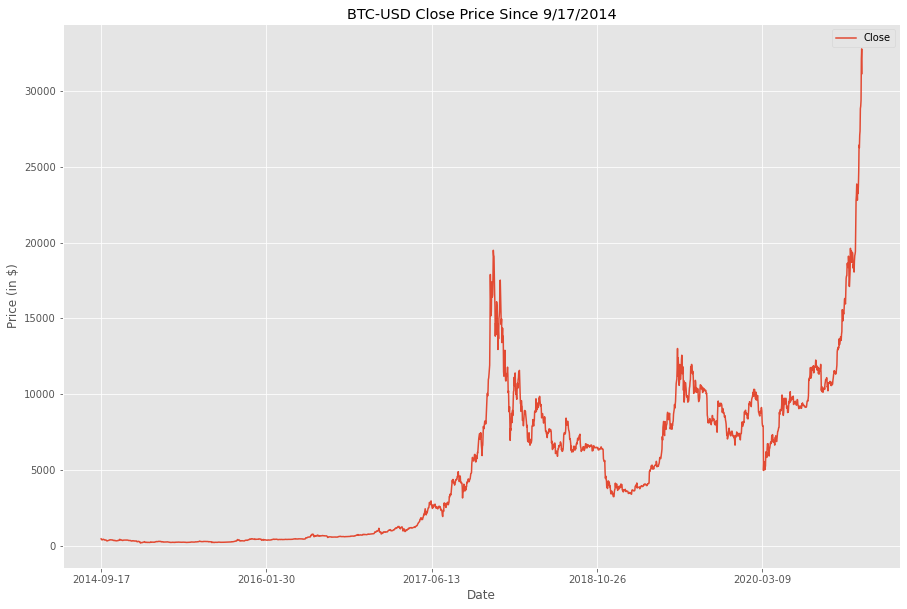

In [564]:
df_btc.plot('Date', 'Close', figsize = (15,10), title = 'BTC-USD Close Price Since 9/17/2014', xlabel = 'Date', ylabel = 'Price (in $)')

In [565]:
df_btc['Volume_Price'] = df_btc['Close'] * df_btc['Volume'] #Volume_Price is the product of Volume and Price for a specific date

In [566]:
df_btc['10_Day_VWAP'] = float('NaN')

In [567]:
for i in range(10, len(df_btc) + 1):
    df_btc['10_Day_VWAP'][i-1] = np.sum(df_btc['Volume_Price'][i-10:i])/np.sum(df_btc['Volume'][i-10:i])
#10-day VWAP is the sum of Volume*Price for each specific day for the past 10 days divided by the sum of Volume for the past 10 days

<ipython-input-567-db1f4227343b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['10_Day_VWAP'][i-1] = np.sum(df_btc['Volume_Price'][i-10:i])/np.sum(df_btc['Volume'][i-10:i])


In [568]:
df_btc['Daily_Return'] = float('NaN')

In [569]:
for i in range(1, len(df_btc)):
    df_btc['Daily_Return'][i] = df_btc['Close'][i]/df_btc['Close'][i-1] - 1
#Daily Return is the percent gain/loss each day compared to the previous day

<ipython-input-569-7e2cb4fb017c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Daily_Return'][i] = df_btc['Close'][i]/df_btc['Close'][i-1] - 1


In [570]:
df_btc['Biweekly_RS'] = float('NaN')

In [571]:
df_btc['Biweekly_RSI'] = float('NaN')

In [572]:
for i in range(13, len(df_btc)):
    daily_gain = 0
    daily_loss = 0
    for j in range(i-13, i+1):
        if df_btc['Daily_Return'][j] >= 0:
            daily_gain += df_btc['Daily_Return'][j]
        else:
            daily_loss += np.abs(df_btc['Daily_Return'][j])
    df_btc['Biweekly_RS'][i] = daily_gain/daily_loss
    daily_gain = 0
    daily_loss = 0
#RS = (Average of Upward Price Change/Average of Downward Price Change)
#the absolute value of the downward price change is applied to the Average of the Downward Price Change to ensure a positive value for RS always

<ipython-input-572-b15556e0893d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Biweekly_RS'][i] = daily_gain/daily_loss


In [573]:
for i in range(13, len(df_btc)):
    df_btc['Biweekly_RSI'][i] = 100 - (100/(1 + df_btc['Biweekly_RS'][i]))
#RSI = 100 – [100/(1 + RS)]
#for Biweekly RSI, the past 14 days are taken into account
#the absolute value of the downward price change is applied to the Average of the Downward Price Change

<ipython-input-573-e89e7b756054>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Biweekly_RSI'][i] = 100 - (100/(1 + df_btc['Biweekly_RS'][i]))


In [574]:
df_btc['12_day_EMA'] = float('NaN')
df_btc['26_day_EMA'] = float('NaN')

In [575]:
for i in range(25, len(df_btc)):
    k_12 = 2/(12+1)
    k_26 = 2/(26+1)
    if i == 25:
        df_btc['12_day_EMA'][i] = np.sum(df_btc['Close'][i-11:i+1])/12
        df_btc['26_day_EMA'][i] = np.sum(df_btc['Close'][i-25:i+1])/26
    else:
        df_btc['12_day_EMA'][i] = df_btc['Close'][i] * k_12 + df_btc['12_day_EMA'][i-1] * (1 - k_12)
        df_btc['26_day_EMA'][i] = df_btc['Close'][i] * k_26 + df_btc['12_day_EMA'][i-1] * (1 - k_26)
#12-day EMA - 26-day EMA = MACD
#After calculating basic 12-day MA and 26-day MA for initial calculations, 
#subsequent calculations of EMA consist of Price(today) * k + EMA(yesterday) * (1 - k), 
#with k = 2/(N + 1) and N = # of days in EMA = 12
#For 26-day EMA, N = 26 instead

<ipython-input-575-2ee7e6c3a2a1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['12_day_EMA'][i] = np.sum(df_btc['Close'][i-11:i+1])/12
<ipython-input-575-2ee7e6c3a2a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['26_day_EMA'][i] = np.sum(df_btc['Close'][i-25:i+1])/26
<ipython-input-575-2ee7e6c3a2a1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['12_day_EMA'][i] = df_btc['Close'][i] * k_12 + df_btc['12_da

In [576]:
df_btc['MACD'] = df_btc['12_day_EMA'] - df_btc['26_day_EMA']

In [577]:
df_btc['Signal'] = float('NaN')

In [578]:
for i in range(33, len(df_btc)):
    k_9 = 2/(9+1)
    if i == 33:
        df_btc['Signal'][i] = np.sum(df_btc['MACD'][i-8:i+1])/9
    else:
        df_btc['Signal'][i] = df_btc['MACD'][i] * k_9 + df_btc['MACD'][i-1] * (1 - k_9)

<ipython-input-578-dee7a3f690e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Signal'][i] = np.sum(df_btc['MACD'][i-8:i+1])/9
<ipython-input-578-dee7a3f690e8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Signal'][i] = df_btc['MACD'][i] * k_9 + df_btc['MACD'][i-1] * (1 - k_9)


In [579]:
df_btc['Trend_Analysis_Close'] = float('NaN')

In [580]:
for i in range(3, len(df_btc)):
    if df_btc['Close'][i] > df_btc['Close'][i-2] and df_btc['Close'][i-1] > df_btc['Close'][i-3]:
        df_btc['Trend_Analysis_Close'][i] = 'UPTREND'
    elif df_btc['Close'][i] < df_btc['Close'][i-2] and df_btc['Close'][i-1] < df_btc['Close'][i-3]:
        df_btc['Trend_Analysis_Close'][i] = 'DOWNTREND'
    else:
        df_btc['Trend_Analysis_Close'][i] = 'N/A'

<ipython-input-580-ed5cd42eae98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Trend_Analysis_Close'][i] = 'DOWNTREND'
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-580-ed5cd42eae98>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Trend_Analysis_Close'][i] = 'N/A'
<ipython-input-580-ed5cd4

In [581]:
len(df_btc)

2302

In [582]:
df_bch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1262 non-null   object 
 1   Open       1262 non-null   float64
 2   High       1262 non-null   float64
 3   Low        1262 non-null   float64
 4   Close      1262 non-null   float64
 5   Adj Close  1262 non-null   float64
 6   Volume     1262 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.1+ KB


In [583]:
df_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [584]:
df_bsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       243 non-null    object 
 1   Open       213 non-null    float64
 2   High       213 non-null    float64
 3   Low        213 non-null    float64
 4   Close      213 non-null    float64
 5   Adj Close  213 non-null    float64
 6   Volume     213 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.4+ KB


In [585]:
df_eos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1284 non-null   object 
 1   Open       1284 non-null   float64
 2   High       1284 non-null   float64
 3   Low        1284 non-null   float64
 4   Close      1284 non-null   float64
 5   Adj Close  1284 non-null   float64
 6   Volume     1284 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 70.3+ KB


In [586]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1978 non-null   object 
 1   Open       1978 non-null   float64
 2   High       1978 non-null   float64
 3   Low        1978 non-null   float64
 4   Close      1978 non-null   float64
 5   Adj Close  1978 non-null   float64
 6   Volume     1978 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.3+ KB


In [587]:
df_ltc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2302 non-null   object 
 1   Open       2302 non-null   float64
 2   High       2302 non-null   float64
 3   Low        2302 non-null   float64
 4   Close      2302 non-null   float64
 5   Adj Close  2302 non-null   float64
 6   Volume     2302 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.0+ KB


In [588]:
df_xrp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2302 non-null   object 
 1   Open       2302 non-null   float64
 2   High       2302 non-null   float64
 3   Low        2302 non-null   float64
 4   Close      2302 non-null   float64
 5   Adj Close  2302 non-null   float64
 6   Volume     2302 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.0+ KB


In [589]:
df_xtz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       243 non-null    object 
 1   Open       230 non-null    float64
 2   High       230 non-null    float64
 3   Low        230 non-null    float64
 4   Close      230 non-null    float64
 5   Adj Close  230 non-null    float64
 6   Volume     230 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.4+ KB


In [590]:
pd.to_datetime(df_btc['Date'], infer_datetime_format = True)
pd.to_datetime(df_bch['Date'], infer_datetime_format = True)
pd.to_datetime(df_bnb['Date'], infer_datetime_format = True)
pd.to_datetime(df_bsv['Date'], infer_datetime_format = True)
pd.to_datetime(df_eos['Date'], infer_datetime_format = True)
pd.to_datetime(df_eth['Date'], infer_datetime_format = True)
pd.to_datetime(df_ltc['Date'], infer_datetime_format = True)
pd.to_datetime(df_xrp['Date'], infer_datetime_format = True)
pd.to_datetime(df_xtz['Date'], infer_datetime_format = True)

0     2020-05-07
1     2020-05-08
2     2020-05-09
3     2020-05-10
4     2020-05-11
         ...    
238   2020-12-31
239   2021-01-01
240   2021-01-02
241   2021-01-03
242   2021-01-04
Name: Date, Length: 243, dtype: datetime64[ns]

<AxesSubplot:title={'center':'10-Day VWAP vs. BTC Close Price Since November 2020'}, xlabel='Date', ylabel='Price (in USD)'>

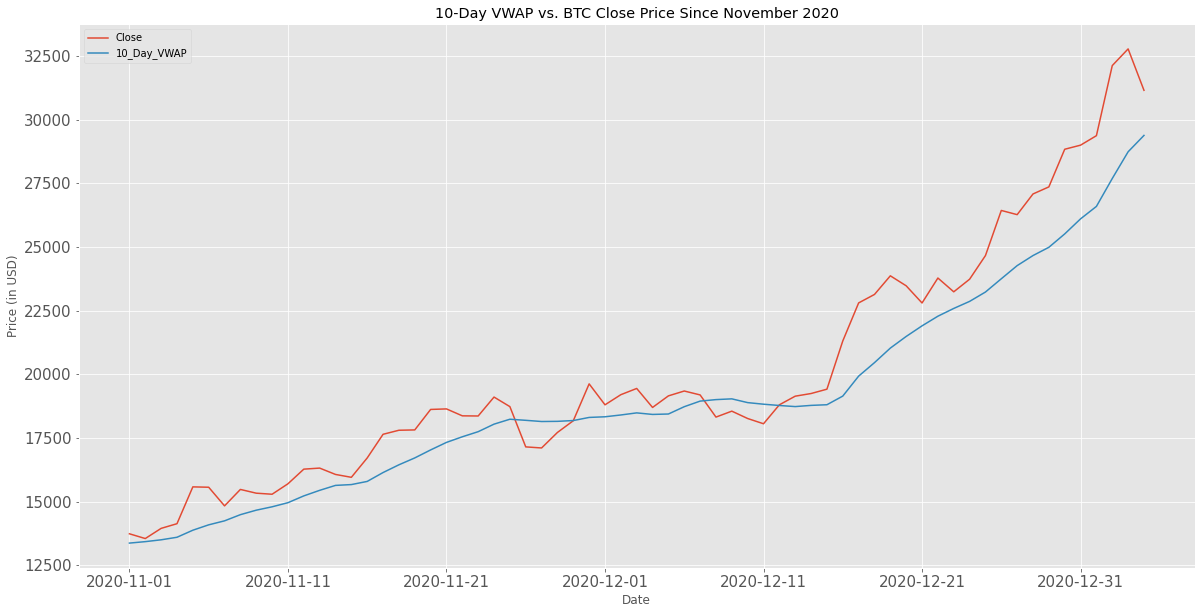

In [591]:
df_btc[df_btc['Date'] >= '2020-11-01'].plot('Date', ['Close', '10_Day_VWAP'], figsize = (20, 10), title = '10-Day VWAP vs. BTC Close Price Since November 2020', ylabel = 'Price (in USD)', fontsize = 15)

<AxesSubplot:title={'center':"BTC's MACD Line vs. Signal Line Since November 2020"}, xlabel='Date', ylabel='EMA (in USD)'>

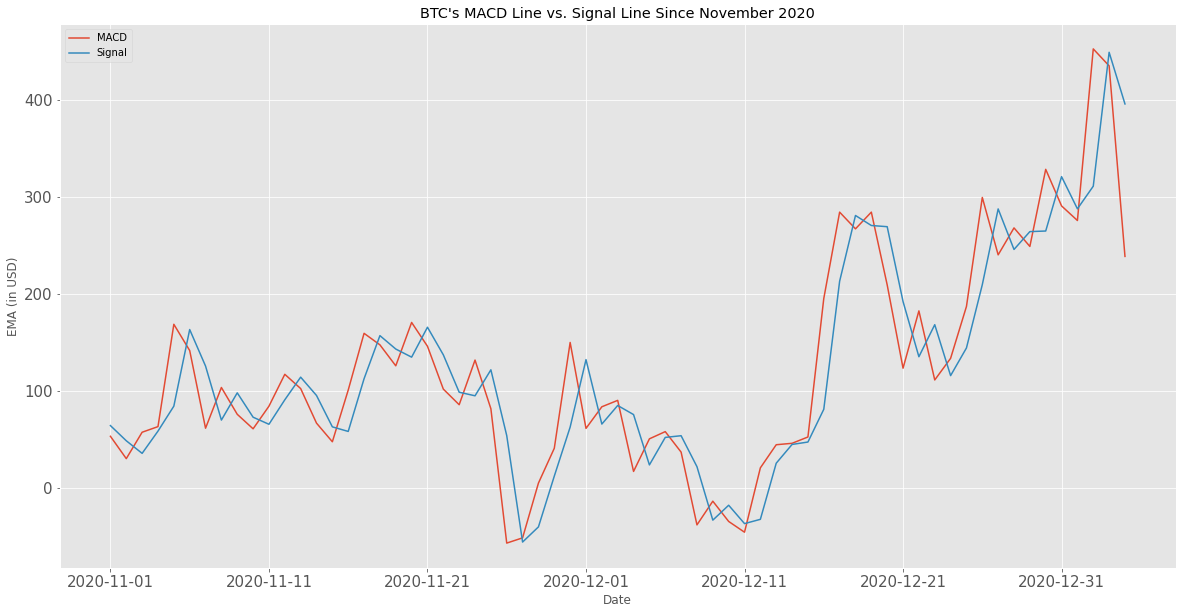

In [592]:
df_btc[df_btc['Date'] >= '2020-11-01'].plot('Date', ['MACD', 'Signal'], figsize = (20, 10), title = 'BTC\'s MACD Line vs. Signal Line Since November 2020', ylabel = 'EMA (in USD)', fontsize = 15)

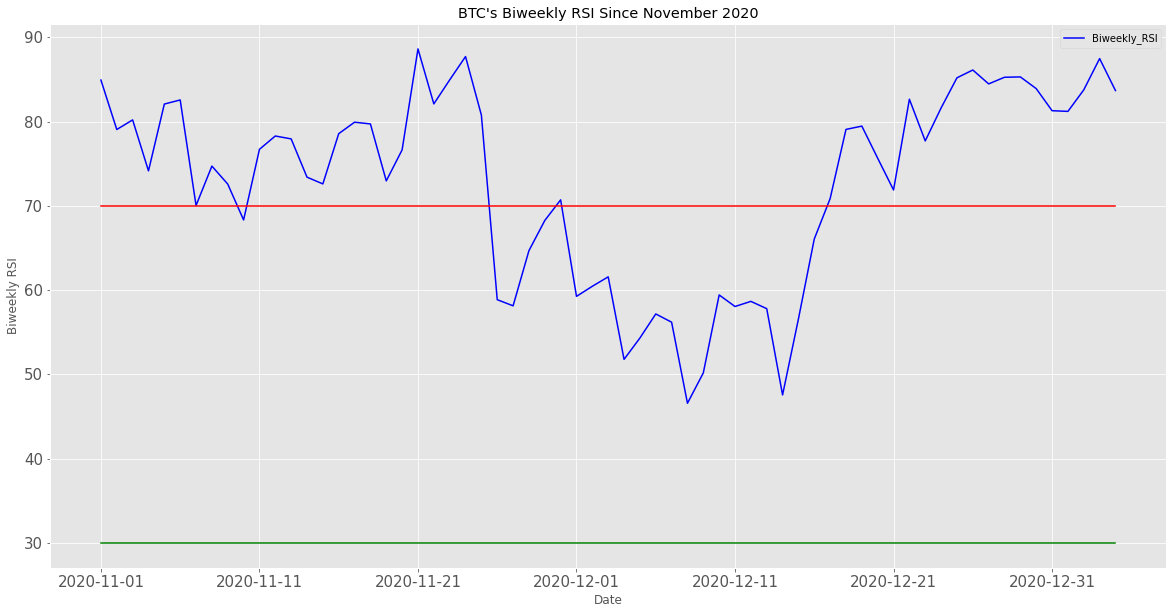

In [593]:
df_btc[df_btc['Date'] >= '2020-11-01'].plot('Date', 'Biweekly_RSI', figsize = (20, 10), title = 'BTC\'s Biweekly RSI Since November 2020', ylabel = 'Biweekly RSI', fontsize = 15, color = 'blue')
plt.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], [70] * len(df_btc[df_btc['Date'] >= '2020-11-01']), color = 'red')
plt.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], [30] * len(df_btc[df_btc['Date'] >= '2020-11-01']), color = 'green')

In [594]:
df_hist = df_btc[df_btc['Date'] >= '2020-03-01'][['Date', 'Daily_Return']]

In [595]:
max_df = df_hist['Daily_Return'].max()

In [596]:
min_df = df_hist['Daily_Return'].min()

In [597]:
bins = int((max_df - min_df)/0.01)

In [598]:
df_hist['Daily_Return_Perc'] = df_hist['Daily_Return'] * 100

Text(0, 0.5, 'Count')

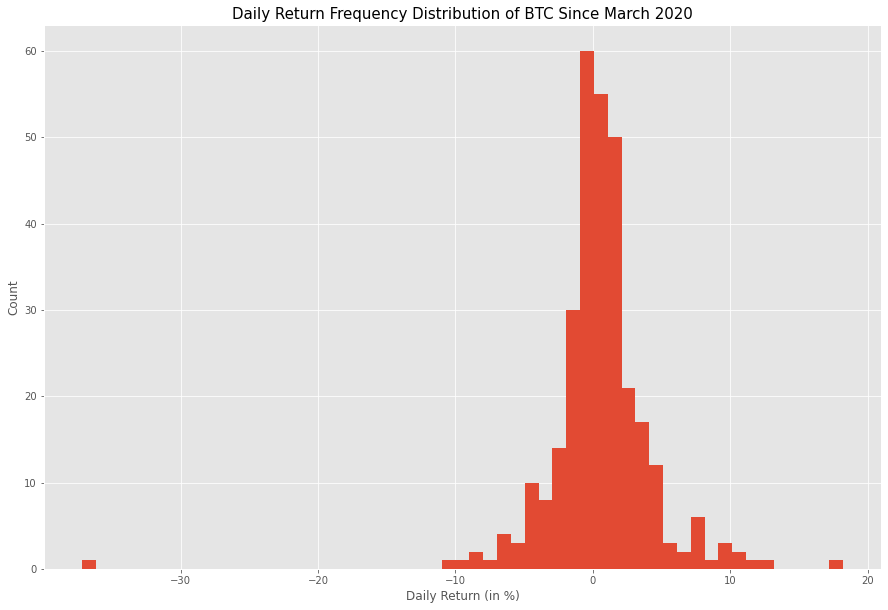

In [599]:
df_hist.hist(column = 'Daily_Return_Perc', bins = bins, figsize = (15, 10))
plt.title('Daily Return Frequency Distribution of BTC Since March 2020', fontsize = 15)
plt.xlabel('Daily Return (in %)')
plt.ylabel('Count')

In [600]:
len(df_hist)

310

In [601]:
#at 99% confidence, 3rd value in from greatest loss; at 95% confidence, 15th value in from greatest loss

In [602]:
df_hist.sort_values('Daily_Return_Perc').head(15)

Date  Daily_Return  Daily_Return_Perc
2003  2020-03-12     -0.371695         -37.169539
2178  2020-09-03     -0.102395         -10.239476
1999  2020-03-08     -0.089993          -8.999349
2062  2020-05-10     -0.087292          -8.729152
2262  2020-11-26     -0.084427          -8.442707
2007  2020-03-16     -0.070069          -7.006916
2005  2020-03-14     -0.065306          -6.530553
2085  2020-06-02     -0.062698          -6.269775
2146  2020-08-02     -0.060034          -6.003427
2032  2020-04-10     -0.059791          -5.979058
2013  2020-03-22     -0.057366          -5.736584
2094  2020-06-11     -0.055553          -5.555301
2020  2020-03-29     -0.051288          -5.128820
2301  2021-01-04     -0.049604          -4.960369
2243  2020-11-07     -0.047034          -4.703408

In [603]:
#Historical VaR
# -9% to -10% loss at 99% confidence, -4% to -5% at 95% confidence based on this time interval from March 1, 2020

In [604]:
df_btc.set_index('Date', drop = True, inplace = True)
df_bch.set_index('Date', drop = True, inplace = True)
df_bnb.set_index('Date', drop = True, inplace = True)
df_bsv.set_index('Date', drop = True, inplace = True)
df_eos.set_index('Date', drop = True, inplace = True)
df_eth.set_index('Date', drop = True, inplace = True)
df_ltc.set_index('Date', drop = True, inplace = True)
df_xrp.set_index('Date', drop = True, inplace = True)
df_xtz.set_index('Date', drop = True, inplace = True)

In [605]:
df_corr = pd.concat([df_btc['Close'], df_bch['Close'], df_bnb['Close'], df_bsv['Close'], 
                     df_eos['Close'], df_eth['Close'], df_ltc['Close'], df_xrp['Close'], df_xtz['Close']], 
                     keys = ['Close_BTC', 'Close_BCH', 'Close_BNB', 'Close_BSV', 'Close_EOS', 'Close_ETH', 'Close_LTC', 
                              'Close_XRP', 'Close_XTZ'], axis = 1)

In [606]:
df_corr[['Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']] = float('NaN')

In [607]:
for i in range(1, len(df_corr)):
    df_corr['Close_BCH_lag_1'][i] = df_corr['Close_BCH'][i-1]
    df_corr['Close_BNB_lag_1'][i] = df_corr['Close_BNB'][i-1]
    df_corr['Close_BSV_lag_1'][i] = df_corr['Close_BSV'][i-1]
    df_corr['Close_EOS_lag_1'][i] = df_corr['Close_EOS'][i-1]
    df_corr['Close_ETH_lag_1'][i] = df_corr['Close_ETH'][i-1]
    df_corr['Close_LTC_lag_1'][i] = df_corr['Close_LTC'][i-1]
    df_corr['Close_XRP_lag_1'][i] = df_corr['Close_XRP'][i-1]
    df_corr['Close_XTZ_lag_1'][i] = df_corr['Close_XTZ'][i-1]

In [608]:
corrMatrix = df_corr[['Close_BTC', 'Close_BCH', 'Close_BNB', 'Close_BSV', 'Close_EOS', 'Close_ETH', 'Close_LTC', 'Close_XRP', 'Close_XTZ']].corr()

<AxesSubplot:>

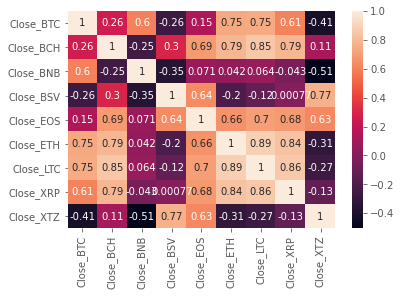

In [609]:
sns.heatmap(corrMatrix, annot=True)

In [610]:
corrMatrix = df_corr[['Close_BTC', 'Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']].corr()

<AxesSubplot:>

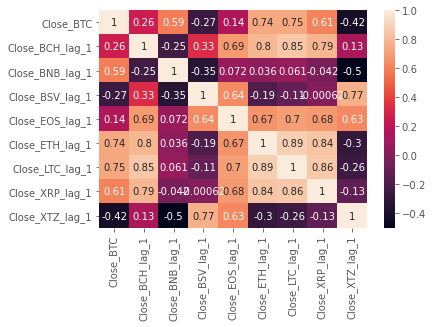

In [611]:
sns.heatmap(corrMatrix, annot=True)

In [612]:
df_corr_time_lag = df_corr[['Close_BTC', 'Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']]

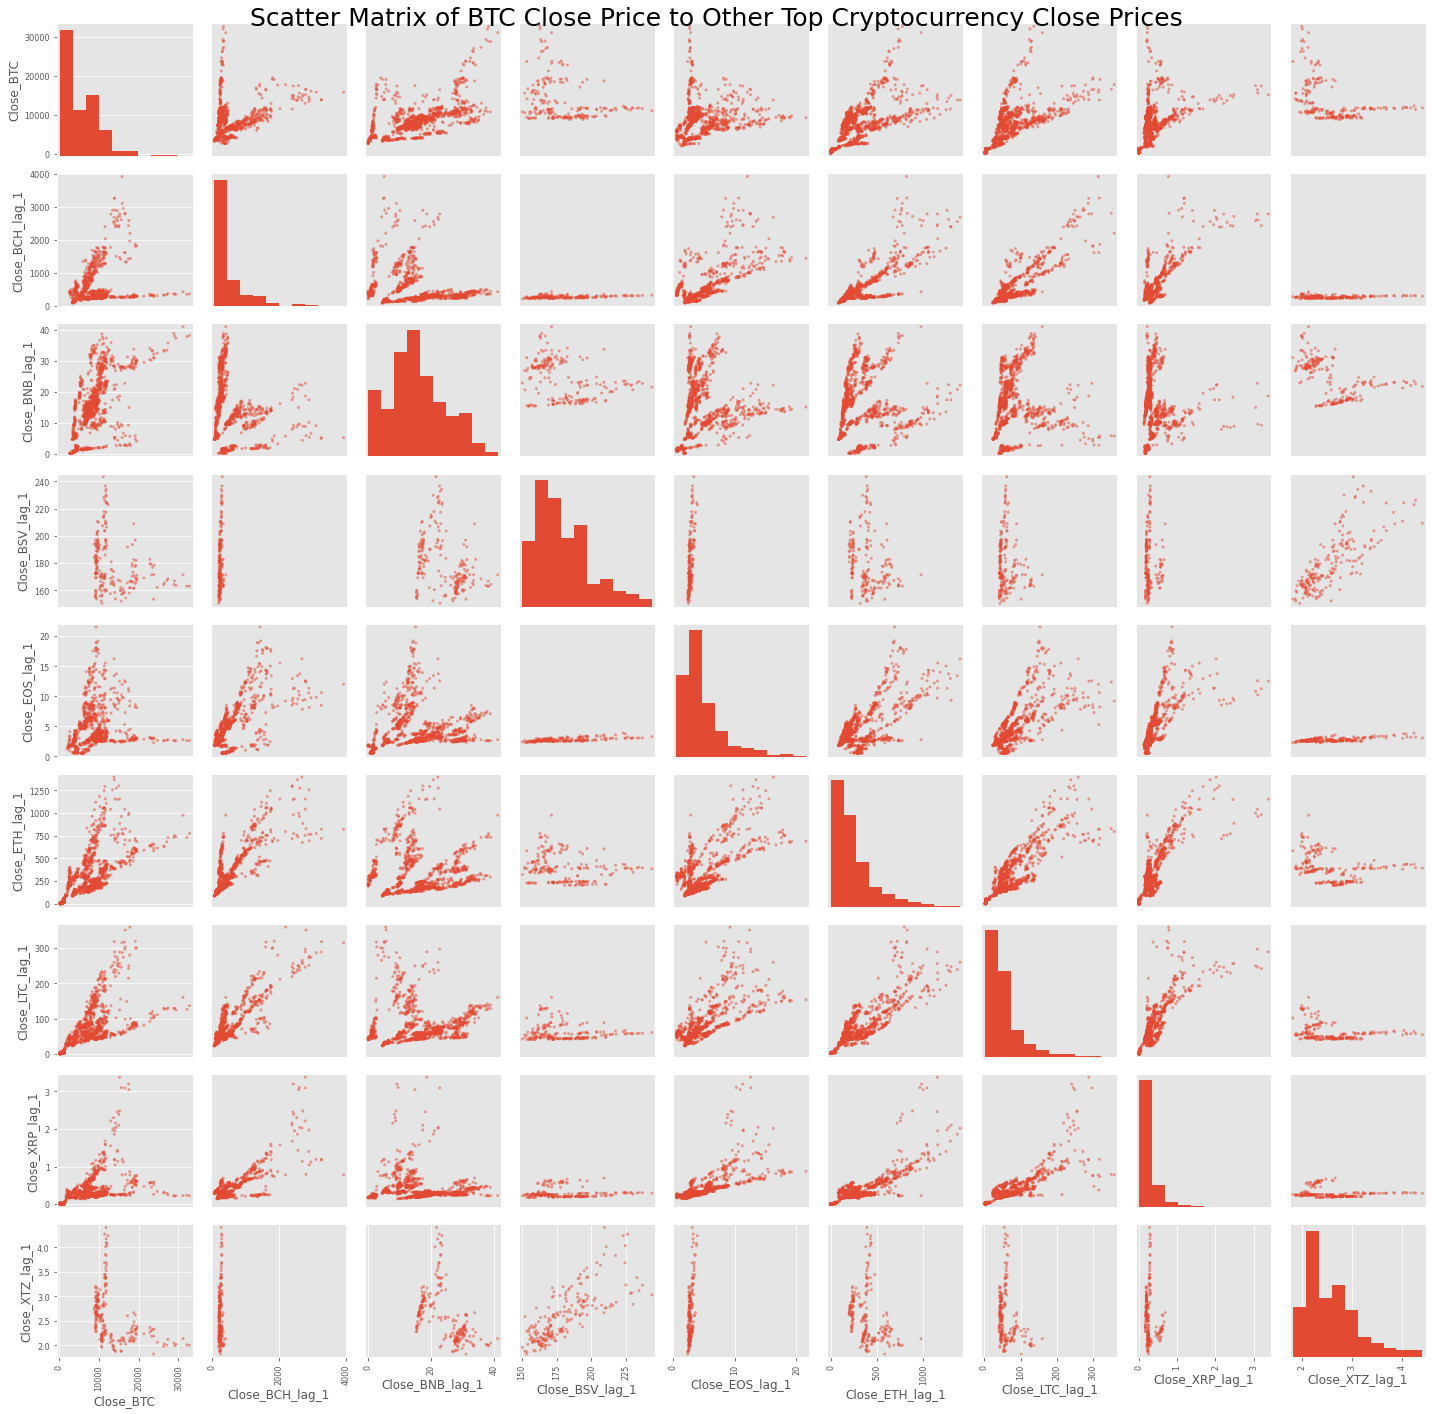

In [613]:
pd.plotting.scatter_matrix(df_corr_time_lag, figsize = (20,20))
plt.suptitle('Scatter Matrix of BTC Close Price to Other Top Cryptocurrency Close Prices', fontsize = 25)
plt.tight_layout()

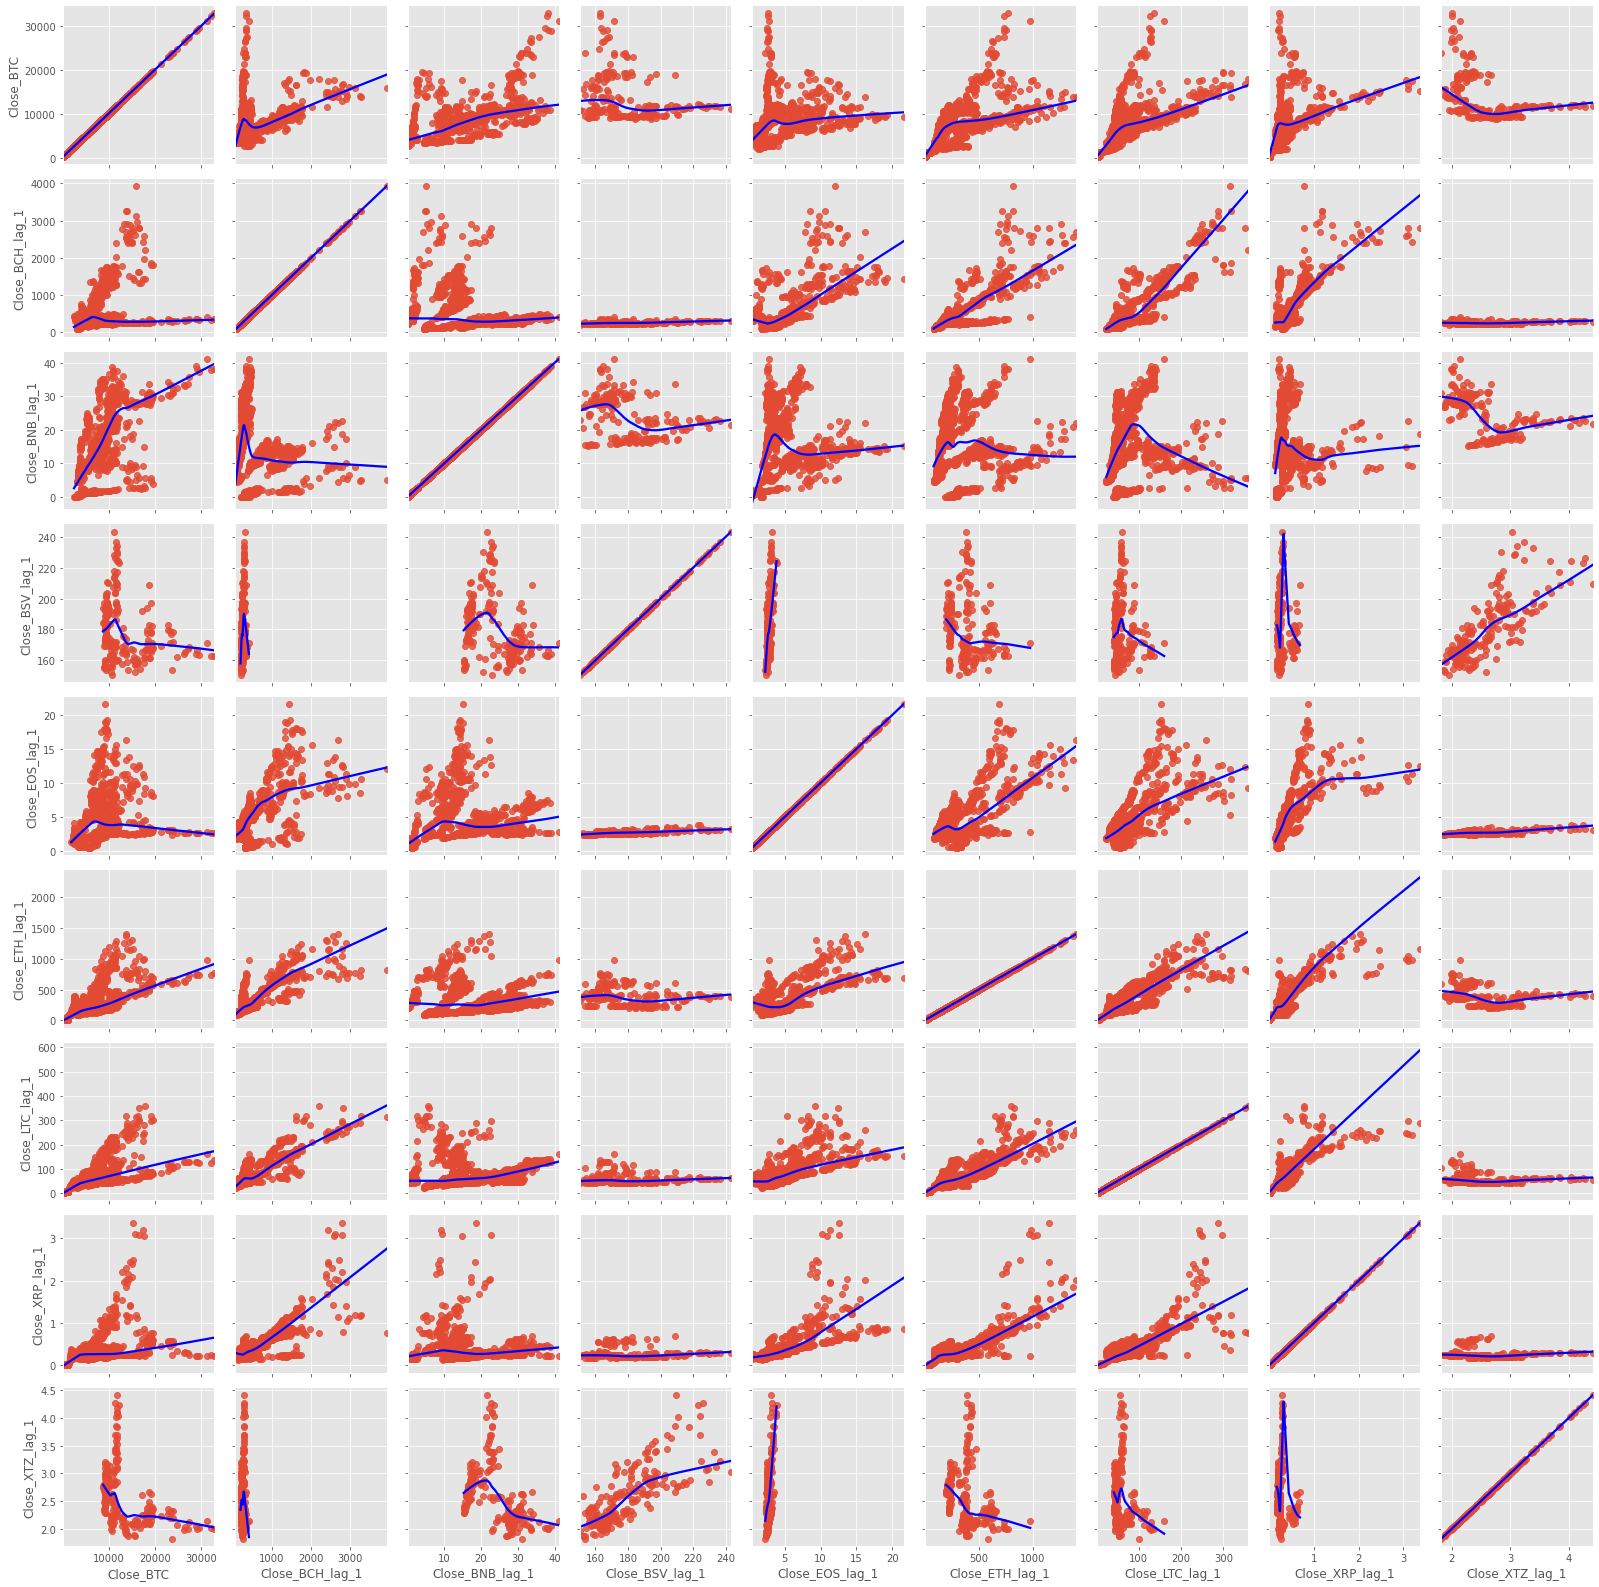

In [614]:
grids = sns.PairGrid(df_corr_time_lag)
grids = grids.map(sns.regplot, lowess=True, scatter = True, line_kws={'color': 'blue'})

In [615]:
#df.corr is NaN tolerant, so no need to account for removing NaN's
df_corr_time_lag.corr()['Close_BTC']

Close_BTC          1.000000
Close_BCH_lag_1    0.257528
Close_BNB_lag_1    0.594031
Close_BSV_lag_1   -0.274059
Close_EOS_lag_1    0.142617
Close_ETH_lag_1    0.738237
Close_LTC_lag_1    0.745392
Close_XRP_lag_1    0.606790
Close_XTZ_lag_1   -0.417357
Name: Close_BTC, dtype: float64

In [616]:
#highest correlation of BTC Close Price among LTC, ETH, XRP, and BNB; will test for multicollinearity in subsequent
#time series model via VIF score, if VIF > 5, multicollinearity exists!
#these correlations consider all available data!!!

In [617]:
#However, for linear trend/seasonal time series baseline model, upward linear trend initiates in March, 2020
#Therefore, correlation from March, 2020 to Present will be considered to add to baseline model

In [618]:
df_corr_baseline = df_corr_time_lag[df_corr_time_lag.index >= '2020-02-01']

In [619]:
corrMatrix_baseline = df_corr_baseline.corr()

<AxesSubplot:>

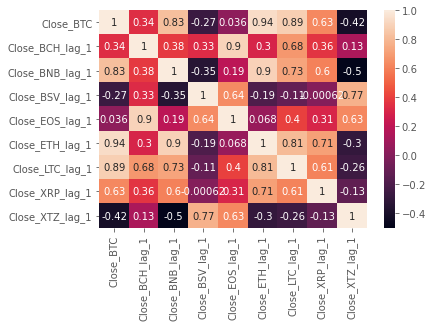

In [620]:
sns.heatmap(corrMatrix_baseline, annot=True)

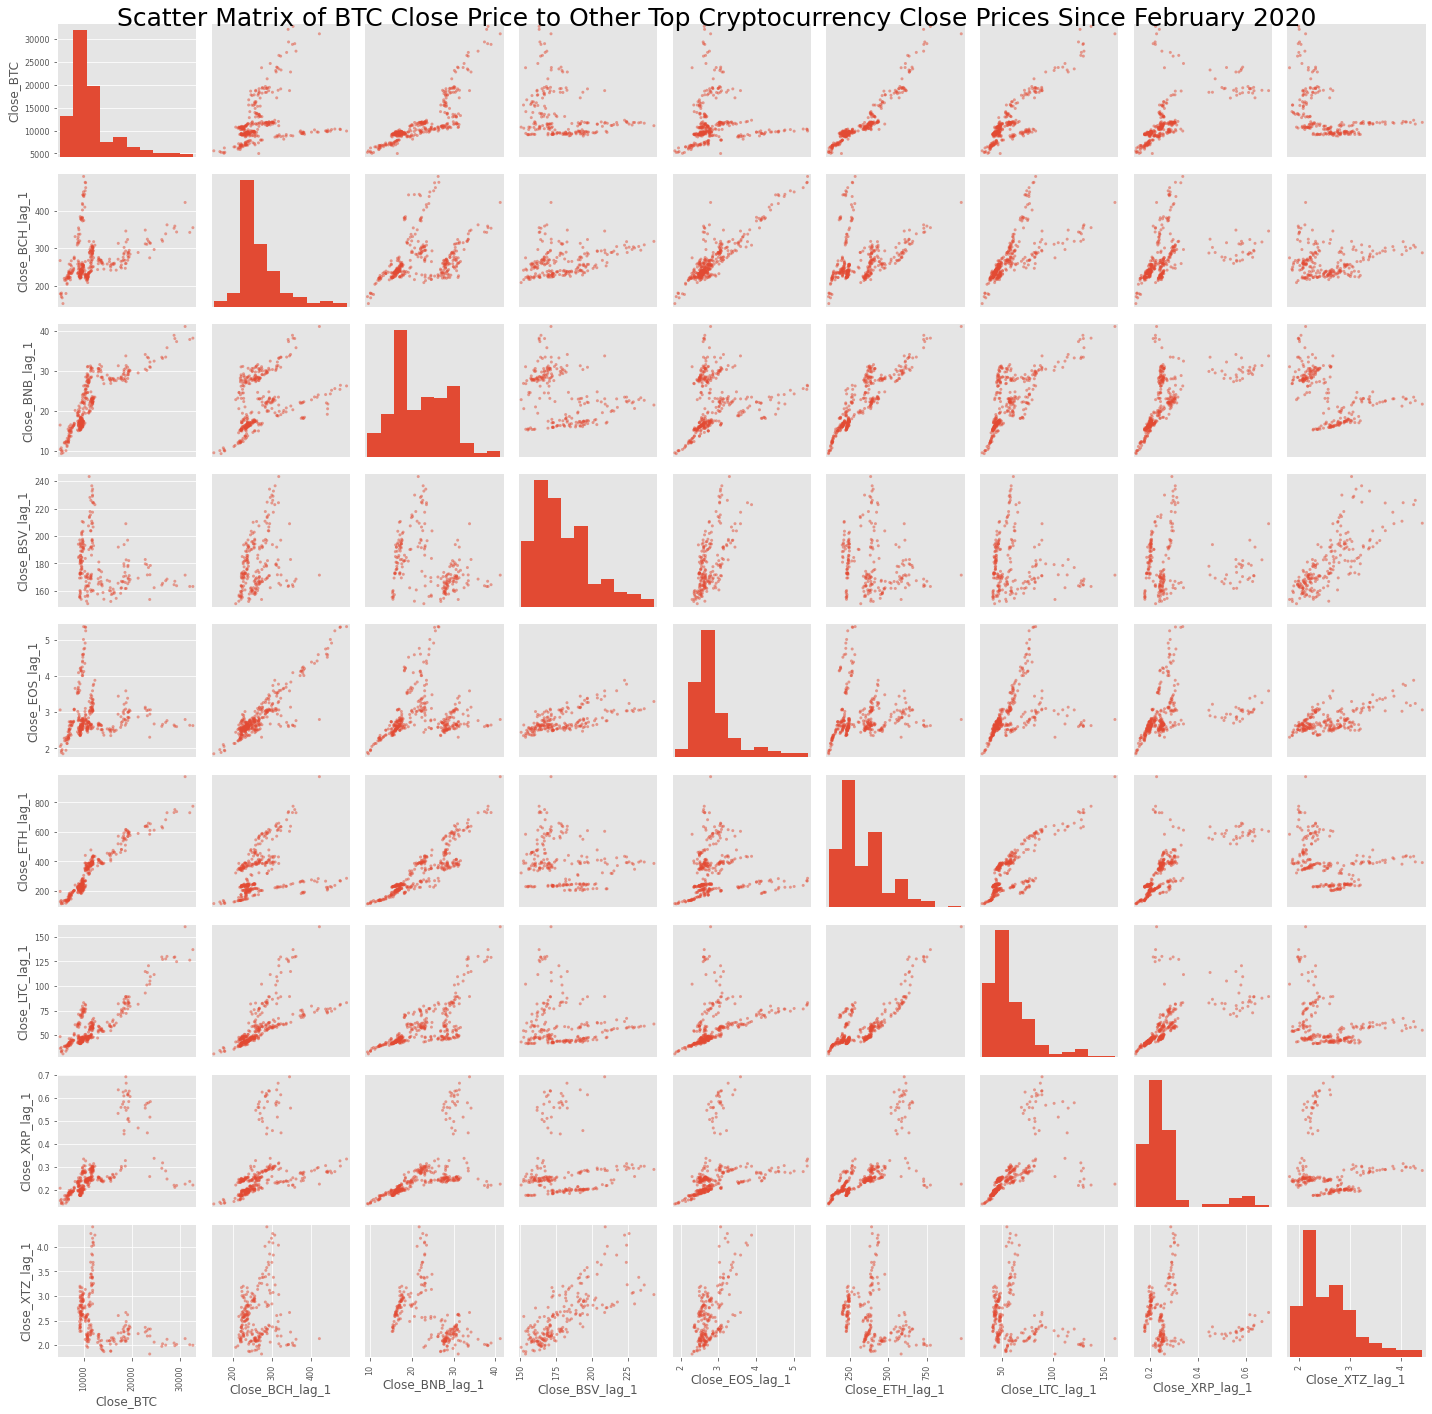

In [621]:
pd.plotting.scatter_matrix(df_corr_baseline, figsize = (20,20))
plt.suptitle('Scatter Matrix of BTC Close Price to Other Top Cryptocurrency Close Prices Since February 2020', fontsize = 25)
plt.tight_layout()

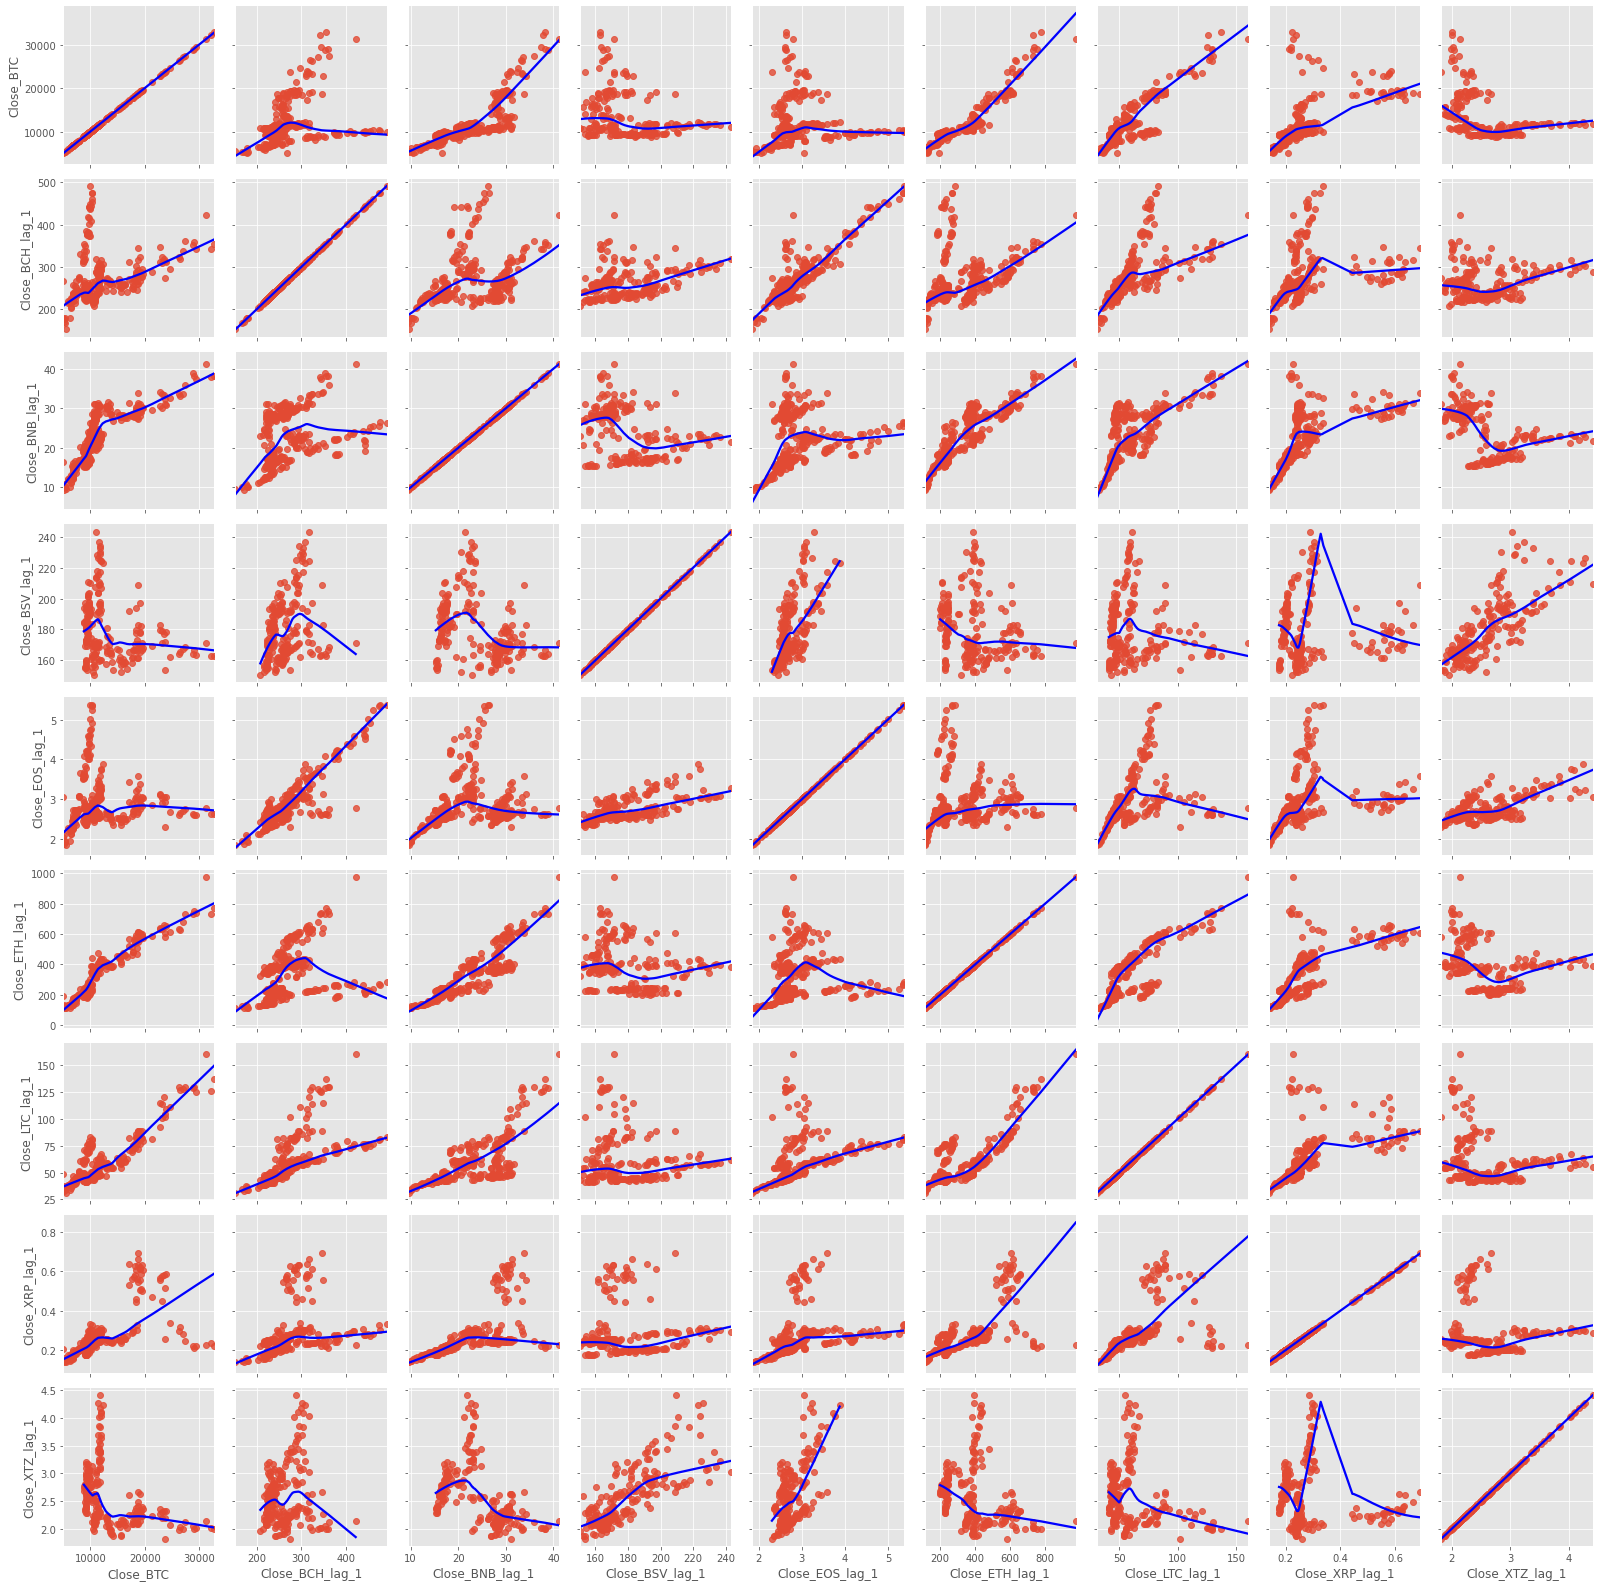

In [622]:
grids = sns.PairGrid(df_corr_baseline)
grids = grids.map(sns.regplot, lowess=True, scatter = True, line_kws={'color': 'blue'})

In [623]:
#highest correlation of BTC Close Price to ETH, LTC, BNB, BCH, and XRP
#will test for multicollinearity of explanatory variables when constructing best-fit model

Text(0, 0.5, 'BTC Closing Price (in USD)')

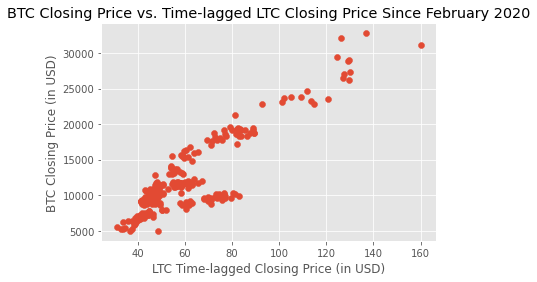

In [624]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_LTC_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged LTC Closing Price Since February 2020')
ax.set_xlabel('LTC Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

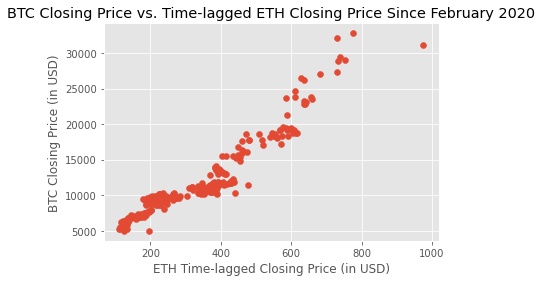

In [625]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_ETH_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged ETH Closing Price Since February 2020')
ax.set_xlabel('ETH Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

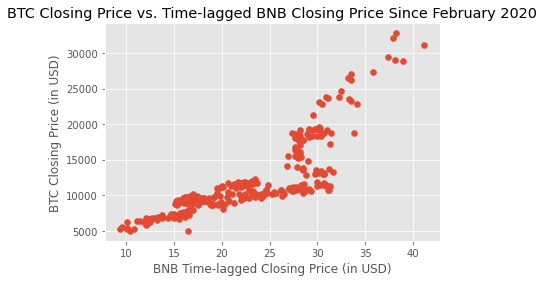

In [626]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_BNB_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged BNB Closing Price Since February 2020')
ax.set_xlabel('BNB Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

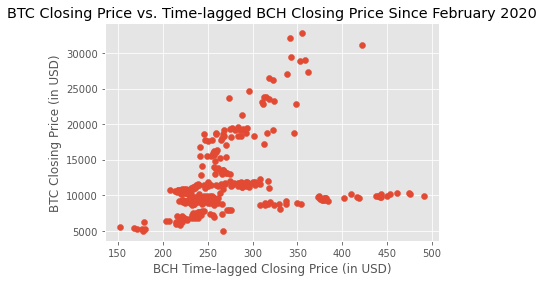

In [627]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_BCH_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged BCH Closing Price Since February 2020')
ax.set_xlabel('BCH Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

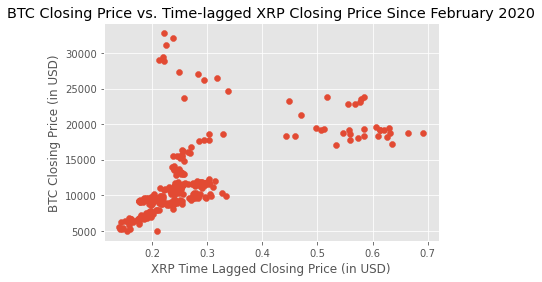

In [628]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_XRP_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged XRP Closing Price Since February 2020')
ax.set_xlabel('XRP Time Lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

In [629]:
df_btc_baseline = df_btc[df_btc.index >= '2020-02-01']

In [630]:
df_btc_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 2020-02-01 to 2021-01-04
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  339 non-null    float64
 1   High                  339 non-null    float64
 2   Low                   339 non-null    float64
 3   Close                 339 non-null    float64
 4   Adj Close             339 non-null    float64
 5   Volume                339 non-null    int64  
 6   Volume_Price          339 non-null    float64
 7   10_Day_VWAP           339 non-null    float64
 8   Daily_Return          339 non-null    float64
 9   Biweekly_RS           339 non-null    float64
 10  Biweekly_RSI          339 non-null    float64
 11  12_day_EMA            339 non-null    float64
 12  26_day_EMA            339 non-null    float64
 13  MACD                  339 non-null    float64
 14  Signal                339 non-null    float64
 15  Trend_Analys

In [631]:
#Since Feb 1, 2020, 339 days have elapsed, so all dates are accounted for
#Relative Time will initiate at Mar 1, 2020 = 0 and Jan 4, 2020 = 338, in terms of days elapsed

In [632]:
df_btc_baseline['Relative_Time'] = float('NaN')

<ipython-input-632-102ab6a989ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_baseline['Relative_Time'] = float('NaN')


In [633]:
for i in range(len(df_btc_baseline)):
    df_btc_baseline['Relative_Time'][i] = i

<ipython-input-633-0fd62e4c6d8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_baseline['Relative_Time'][i] = i
C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [634]:
model1 = ols('np.log(Close) ~ Relative_Time', data = df_btc_baseline).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Close)   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     781.8
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           8.07e-90
Time:                        12:28:46   Log-Likelihood:                 74.645
No. Observations:                 339   AIC:                            -145.3
Df Residuals:                     337   BIC:                            -137.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.7796      0.021    415.993      0.000       8.738       8.821
Relative_Time     0.0030      0.000     27.960      0.000       0.003       0.003
==============================================================================
Omnibus:                       29.563   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.286
Skew:                           0.788   Prob(JB):                     2.18e-08
Kurtosis:                       3.127   Cond. No.                         390.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [635]:
df_btc_baseline_model1 = stat()
df_btc_baseline_model1.anova_stat(df = df_btc_baseline, res_var='Close', anova_model='np.log(Close) ~ Relative_Time')
df_btc_baseline_model1.anova_summary

df     sum_sq    mean_sq           F        PR(>F)
Relative_Time    1.0  29.643476  29.643476  781.787147  8.068109e-90
Residual       337.0  12.778224   0.037918         NaN           NaN

In [636]:
model1_fitted_y_values = model1.fittedvalues
model1_norm_resids = df_btc_baseline_model1.anova_std_residuals
model1_norm_resids_abs_sqrt = np.sqrt(np.abs(model1_norm_resids))
model1_lev = model1.get_influence().hat_matrix_diag

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

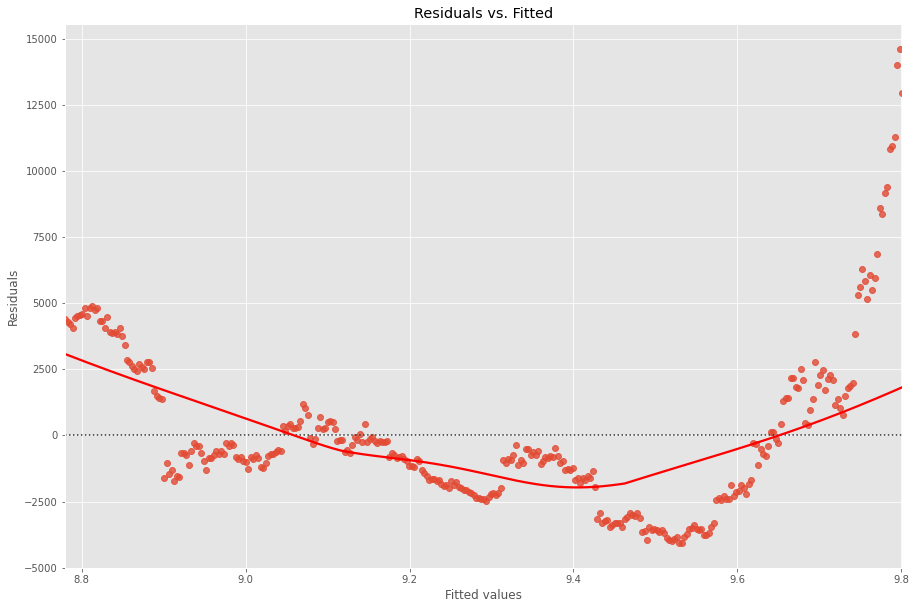

In [637]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model1_fitted_y_values, df_btc_baseline['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
#AUTOREGRESSION EVIDENT

Text(0, 0.5, 'Standardized residuals')

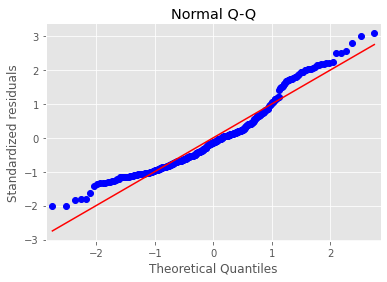

In [638]:
QQ = sgg.ProbPlot(model1_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

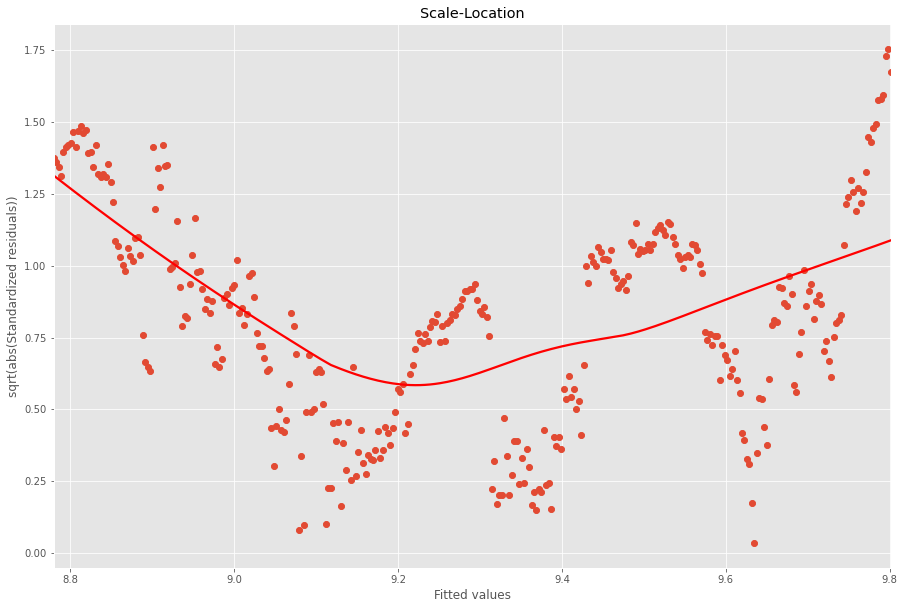

In [639]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model1_fitted_y_values, model1_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model1_fitted_y_values, model1_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('sqrt(abs(Standardized residuals))')
#Autoregression EVIDENT

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Standardized Residuals')

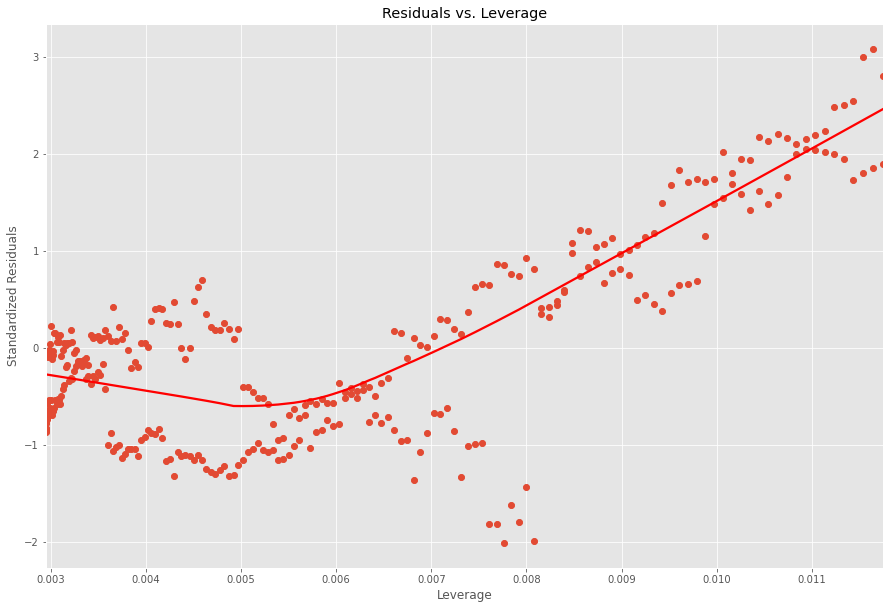

In [640]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model1_lev, model1_norm_resids)
sns.regplot(model1_lev, model1_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')

In [641]:
#Baseline model, model1, will be used as a comparison in terms of improving R^2 score of subsequent models
#Based on assumptions of linear regression, i.e. a general linear trend between the response/explanatory variables,
#no multicollinearity amongst its' explanatory variables, normality of its' residuals, and randomness of its' residuals 
#with constant variation; there is no randomness to its' errors, i.e. there is an autoregressive/cyclical nature to them,
#therefore this baseline model is not appropriate/cannot be used

In [642]:
#incorporate monthly seasonality into model
df_btc_baseline['Month'] = pd.to_datetime(df_btc_baseline.index).month

<ipython-input-642-148f3a3cbba9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_baseline['Month'] = pd.to_datetime(df_btc_baseline.index).month


In [643]:
df_dummies_months = pd.get_dummies(df_btc_baseline['Month'], drop_first = False)
df_dummies_months.columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']

In [644]:
#df_btc_baseline.drop('Month', axis = 1, inplace = True)

In [645]:
df_btc_baseline_dummies = pd.concat([df_btc_baseline, df_dummies_months], axis = 1)

In [646]:
model2 = ols('np.log(Close) ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan', data = df_btc_baseline_dummies).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Close)   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     399.3
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          8.94e-187
Time:                        12:28:53   Log-Likelihood:                 337.99
No. Observations:                 339   AIC:                            -650.0
Df Residuals:                     326   BIC:                            -600.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.1629      0.094     86.485      0.000       7.977       8.349
Relative_Time     0.0029      0.001      5.126      0.000       0.002       0.004
Feb               1.2138      0.105     11.562      0.000       1.007       1.420
Mar               0.9680      0.088     11.017      0.000       0.795       1.141
Apr               0.5255      0.071      7.384      0.000       0.385       0.665
May               0.5039      0.055      9.236      0.000       0.397       0.611
Jun               0.6657      0.038     17.365      0.000       0.590       0.741
Jul               0.6018      0.024     25.143      0.000       0.555       0.649
Aug               0.5219      0.016     32.595      0.000       0.490       0.553
Sep               0.6289      0.024     26.760      0.000       0.583       0.675
Oct               0.4511      0.038     11.840      0.000       0.376       0.526
Nov               0.4685      0.054      8.655      0.000       0.362       0.575
Dec               0.7153      0.071     10.095      0.000       0.576       0.855
Jan               0.8987      0.088     10.248      0.000       0.726       1.071
==============================================================================
Omnibus:                       44.415   Durbin-Watson:                   0.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.018
Skew:                           0.562   Prob(JB):                     2.91e-30
Kurtosis:                       5.892   Cond. No.                     1.39e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.69e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [647]:
df_btc_baseline_model2 = stat()
df_btc_baseline_model2.anova_stat(df = df_btc_baseline_dummies, res_var='Close', 
                                  anova_model='np.log(Close) ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan')
df_btc_baseline_model2.anova_summary

df    sum_sq   mean_sq            F         PR(>F)
Relative_Time    1.0  0.217796  0.217796    26.275787   5.083031e-07
Feb              1.0  1.107991  1.107991   133.672606   3.849222e-26
Mar              1.0  1.005969  1.005969   121.364230   3.322619e-24
Apr              1.0  0.451990  0.451990    54.529885   1.289403e-12
May              1.0  0.707057  0.707057    85.302272   3.371980e-18
Jun              1.0  2.499344  2.499344   301.531115   2.771089e-48
Jul              1.0  5.240104  5.240104   632.187797   2.586042e-78
Aug              1.0  8.806369  8.806369  1062.436723  1.334812e-104
Sep              1.0  5.935451  5.935451   716.077311   2.901657e-84
Oct              1.0  1.161911  1.161911   140.177703   3.832501e-27
Nov              1.0  0.620841  0.620841    74.900775   2.307511e-16
Dec              1.0  0.844725  0.844725   101.911106   4.968960e-21
Jan              1.0  0.870504  0.870504   105.021210   1.509321e-21
Residual       326.0  2.702162  0.008289          NaN            NaN

In [648]:
model2_fitted_y_values = model2.fittedvalues
model2_norm_resids = df_btc_baseline_model2.anova_std_residuals
model2_norm_resids_abs_sqrt = np.sqrt(np.abs(model2_norm_resids))
model2_lev = model2.get_influence().hat_matrix_diag

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

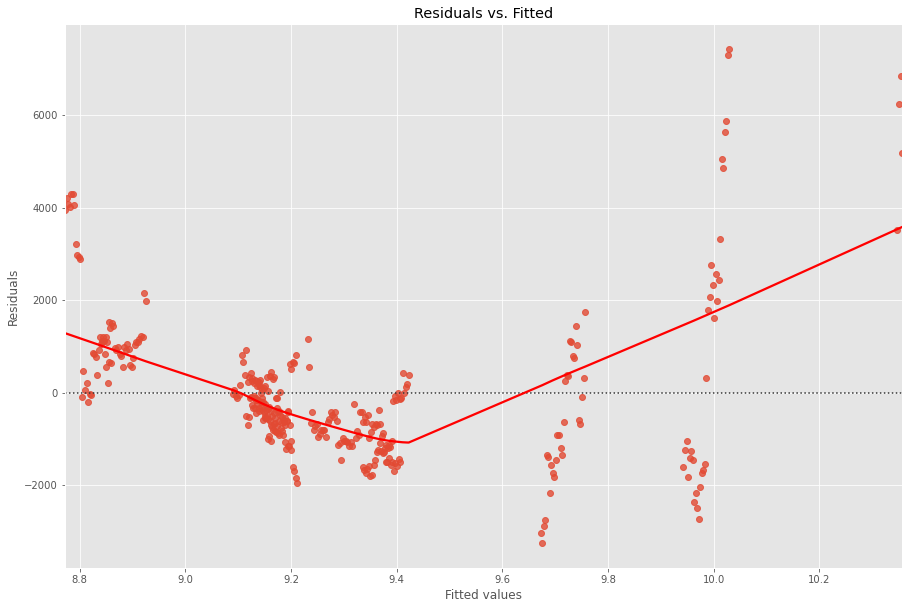

In [649]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model2_fitted_y_values, df_btc_baseline_dummies['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

Text(0, 0.5, 'Standardized residuals')

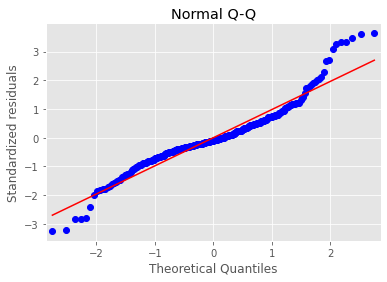

In [650]:
QQ = sgg.ProbPlot(model2_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

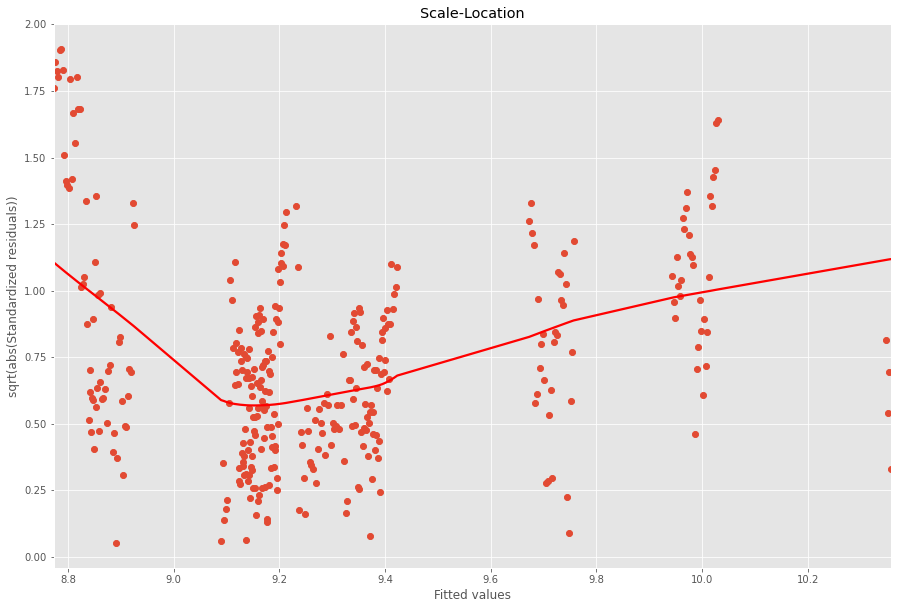

In [651]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model2_fitted_y_values, model2_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model2_fitted_y_values, model2_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('sqrt(abs(Standardized residuals))')
#constant variation and randomness of errors/residuals

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Standardized Residuals')

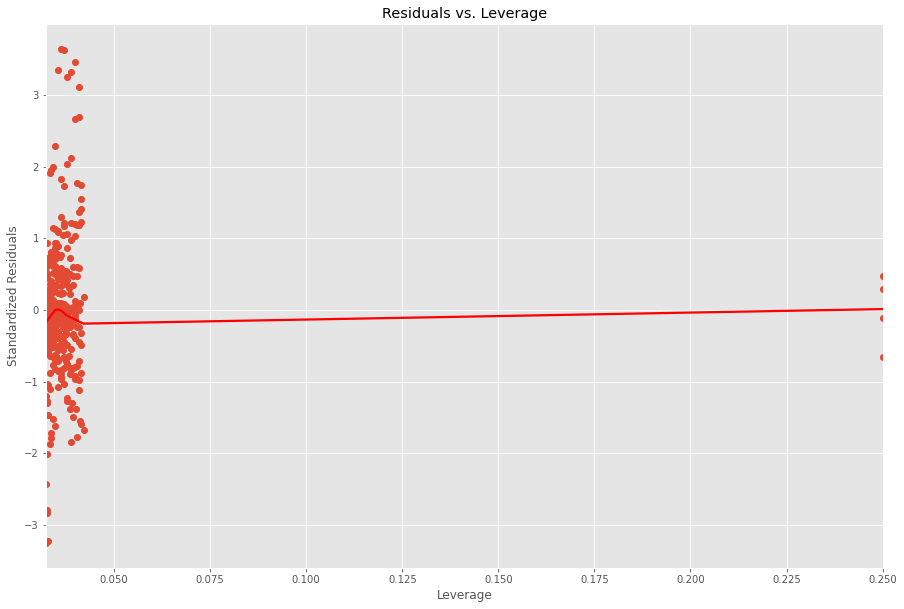

In [652]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model2_lev, model2_norm_resids)
sns.regplot(model2_lev, model2_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')

In [653]:
y_pred_2 = model2.predict(df_btc_baseline_dummies[['Relative_Time', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']])

In [654]:
y_pred_1 = model1.predict(df_btc_baseline['Relative_Time'])

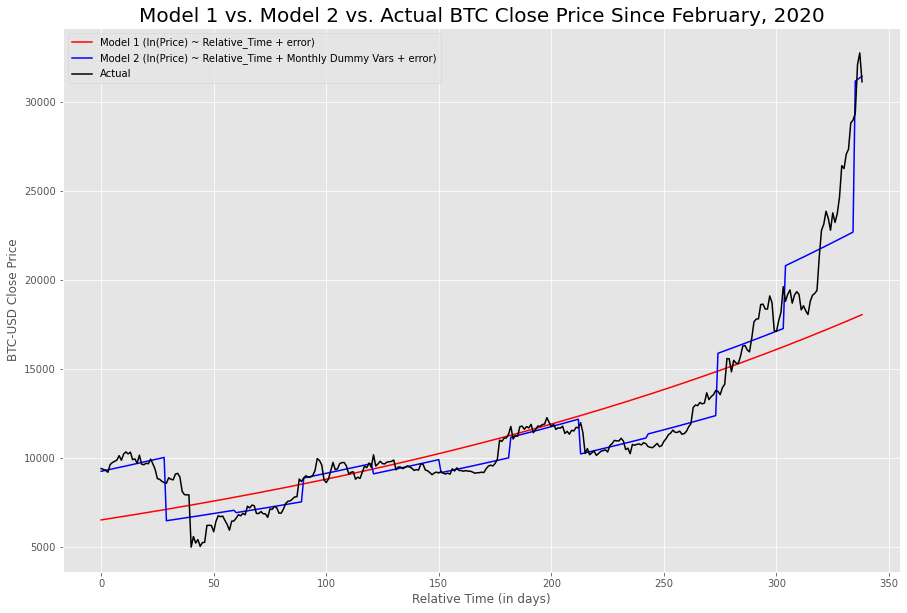

In [655]:
from math import e
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_baseline_dummies['Relative_Time']
actual = df_btc_baseline['Close']
ax.plot(t, e**y_pred_1, color = 'red', label = 'Model 1 (ln(Price) ~ Relative_Time + error)')
ax.plot(t, e**y_pred_2, color = 'blue', label = 'Model 2 (ln(Price) ~ Relative_Time + Monthly Dummy Vars + error)')
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.set_title('Model 1 vs. Model 2 vs. Actual BTC Close Price Since February, 2020', fontsize = 20)
ax.set_xlabel('Relative Time (in days)')
ax.set_ylabel('BTC-USD Close Price')
plt.legend()

In [656]:
#Strengthen model with correlated cryptocurrencies of ETH, LTC, BNB, BCH, and XRP

In [657]:
df_btc_CCC_dummies = pd.concat([df_btc_baseline_dummies, df_corr_baseline[['Close_LTC_lag_1', 'Close_ETH_lag_1', 'Close_BNB_lag_1', 'Close_BCH_lag_1', 'Close_XRP_lag_1']]], axis = 1)

In [658]:
df_btc_CCC_dummies.info() #all non-null values!

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 2020-02-01 to 2021-01-04
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  339 non-null    float64
 1   High                  339 non-null    float64
 2   Low                   339 non-null    float64
 3   Close                 339 non-null    float64
 4   Adj Close             339 non-null    float64
 5   Volume                339 non-null    int64  
 6   Volume_Price          339 non-null    float64
 7   10_Day_VWAP           339 non-null    float64
 8   Daily_Return          339 non-null    float64
 9   Biweekly_RS           339 non-null    float64
 10  Biweekly_RSI          339 non-null    float64
 11  12_day_EMA            339 non-null    float64
 12  26_day_EMA            339 non-null    float64
 13  MACD                  339 non-null    float64
 14  Signal                339 non-null    float64
 15  Trend_Analys

In [659]:
model3 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan + Close_LTC_lag_1 + Close_ETH_lag_1 + Close_BNB_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model3.summary()
#Close_BNB_lag_1's t-stat p-value is largest and greater than an alpha of 0.05, therefore it is statistically insignificant
#in describing the variation in BTC's Close Price for this time interval, will drop in subsequent model
#Mar is default month and is removed from set of monthly dummy variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1449.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          9.27e-292
Time:                        12:29:05   Log-Likelihood:                -2622.5
No. Observations:                 339   AIC:                             5281.
Df Residuals:                     321   BIC:                             5350.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -107.8811    532.622     -0.203      0.840   -1155.752     939.990
Relative_Time      32.6838      4.416      7.401      0.000      23.995      41.372
Feb              3812.8722   1213.050      3.143      0.002    1426.340    6199.404
Apr               -58.1339    254.962     -0.228      0.820    -559.741     443.473
May              -394.0465    315.865     -1.248      0.213   -1015.473     227.380
Jun               476.2653    400.285      1.190      0.235    -311.248    1263.779
Jul              -236.6711    509.027     -0.465      0.642   -1238.122     764.780
Aug             -1127.5027    614.682     -1.834      0.068   -2336.817      81.812
Sep             -1542.8955    726.878     -2.123      0.035   -2972.943    -112.848
Oct             -2148.3762    832.349     -2.581      0.010   -3785.925    -510.828
Nov             -2147.9016    946.460     -2.269      0.024   -4009.950    -285.853
Dec              -292.7578   1031.610     -0.284      0.777   -2322.328    1736.812
Jan               690.5273   1119.687      0.617      0.538   -1512.325    2893.379
Close_LTC_lag_1   131.0769      8.225     15.936      0.000     114.895     147.259
Close_ETH_lag_1    -1.7683      1.917     -0.923      0.357      -5.539       2.002
Close_BNB_lag_1    -3.6172     27.313     -0.132      0.895     -57.351      50.117
Close_BCH_lag_1     2.5986      2.372      1.096      0.274      -2.068       7.265
Close_XRP_lag_1 -3048.1899    618.011     -4.932      0.000   -4264.054   -1832.326
==============================================================================
Omnibus:                       44.310   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.780
Skew:                          -0.210   Prob(JB):                     1.61e-64
Kurtosis:                       7.541   Cond. No.                     3.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [660]:
model4 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan + Close_LTC_lag_1 + Close_ETH_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model4.summary()
#Close_ETH's t-stat p-value is largest among the other cryptocurrencies and greater than an alpha of 0.05, therefore it 
#is statistically insignificant in describing the variation in BTC's Close Price for this time interval, 
#will drop in subsequent model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1545.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          2.34e-293
Time:                        12:29:05   Log-Likelihood:                -2622.5
No. Observations:                 339   AIC:                             5279.
Df Residuals:                     322   BIC:                             5344.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -107.3293    531.793     -0.202      0.840   -1153.556     938.898
Relative_Time      32.5331      4.261      7.636      0.000      24.151      40.915
Feb              3823.1833   1208.700      3.163      0.002    1445.236    6201.130
Apr               -56.5333    254.286     -0.222      0.824    -556.805     443.739
May              -391.2447    314.674     -1.243      0.215   -1010.322     227.832
Jun               480.7474    398.243      1.207      0.228    -302.739    1264.234
Jul              -225.9864    501.826     -0.450      0.653   -1213.258     761.285
Aug             -1115.4187    606.944     -1.838      0.067   -2309.496      78.658
Sep             -1528.0207    717.052     -2.131      0.034   -2938.719    -117.322
Oct             -2150.6340    830.904     -2.588      0.010   -3785.320    -515.948
Nov             -2157.7766    942.078     -2.290      0.023   -4011.182    -304.372
Dec              -288.3175   1029.491     -0.280      0.780   -2313.695    1737.059
Jan               700.5734   1115.409      0.628      0.530   -1493.836    2894.983
Close_LTC_lag_1   131.1271      8.204     15.984      0.000     114.987     147.267
Close_ETH_lag_1    -1.8246      1.866     -0.978      0.329      -5.496       1.846
Close_BCH_lag_1     2.4194      1.945      1.244      0.214      -1.407       6.246
Close_XRP_lag_1 -3031.0313    603.355     -5.024      0.000   -4218.047   -1844.015
==============================================================================
Omnibus:                       44.003   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.320
Skew:                          -0.208   Prob(JB):                     1.50e-63
Kurtosis:                       7.507   Cond. No.                     3.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [661]:
model5 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan + Close_LTC_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model5.summary()
#Close_BCH_lag_1's t-stat p-value is largest among the other cryptocurrencies and greater than an alpha of 0.05, 
#therefore it is statistically insignificant in describing the variation in BTC's Close Price for this time interval, 
#will drop in subsequent model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1648.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          9.13e-295
Time:                        12:29:05   Log-Likelihood:                -2623.0
No. Observations:                 339   AIC:                             5278.
Df Residuals:                     323   BIC:                             5339.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         100.7918    487.311      0.207      0.836    -857.912    1059.496
Relative_Time      30.9653      3.947      7.845      0.000      23.200      38.731
Feb              3587.6340   1184.373      3.029      0.003    1257.574    5917.694
Apr              -111.0607    248.080     -0.448      0.655    -599.117     376.996
May              -420.4464    313.233     -1.342      0.180   -1036.680     195.788
Jun               447.4456    396.757      1.128      0.260    -333.109    1228.000
Jul              -269.7805    499.789     -0.540      0.590   -1253.034     713.473
Aug             -1143.3986    606.228     -1.886      0.060   -2336.053      49.256
Sep             -1648.8790    706.272     -2.335      0.020   -3038.352    -259.406
Oct             -2264.1864    822.694     -2.752      0.006   -3882.701    -645.672
Nov             -2216.4398    940.102     -2.358      0.019   -4065.936    -366.944
Dec              -356.1088   1027.084     -0.347      0.729   -2376.728    1664.510
Jan               629.4433   1112.959      0.566      0.572   -1560.121    2819.008
Close_LTC_lag_1   126.0620      6.361     19.817      0.000     113.547     138.577
Close_BCH_lag_1     1.9970      1.896      1.053      0.293      -1.734       5.728
Close_XRP_lag_1 -3317.0453    527.680     -6.286      0.000   -4355.170   -2278.921
==============================================================================
Omnibus:                       51.017   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.732
Skew:                          -0.305   Prob(JB):                     1.15e-81
Kurtosis:                       8.101   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [662]:
model6 = ols('Close ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_XRP_lag_1 + Close_LTC_lag_1', 
             data = df_btc_CCC_dummies).fit()
model6.summary()
#Dec, Jul, and Apr's t-stat p-values were greater than an alpha of 0.05, therefore they were statistically insignificant
#in describing the variation in BTC's Close Price for this time interval, dropped from model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2258.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          6.90e-301
Time:                        12:29:06   Log-Likelihood:                -2624.2
No. Observations:                 339   AIC:                             5272.
Df Residuals:                     327   BIC:                             5318.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         187.4233    174.498      1.074      0.284    -155.857     530.704
Relative_Time      28.8523      0.515     56.059      0.000      27.840      29.865
Feb              3752.0174    384.365      9.762      0.000    2995.878    4508.157
May              -293.5557    123.722     -2.373      0.018    -536.946     -50.165
Jun               626.8388    119.475      5.247      0.000     391.803     861.875
Aug              -841.6592    123.878     -6.794      0.000   -1085.358    -597.960
Sep             -1322.7586    119.994    -11.024      0.000   -1558.816   -1086.701
Oct             -1895.1976    131.173    -14.448      0.000   -2153.247   -1637.149
Nov             -1764.3967    136.498    -12.926      0.000   -2032.921   -1495.872
Jan               843.0414    182.725      4.614      0.000     483.577    1202.506
Close_XRP_lag_1 -2939.2880    454.285     -6.470      0.000   -3832.978   -2045.598
Close_LTC_lag_1   134.1209      2.865     46.811      0.000     128.484     139.757
==============================================================================
Omnibus:                       54.507   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.478
Skew:                          -0.356   Prob(JB):                     4.45e-90
Kurtosis:                       8.350   Cond. No.                     3.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [663]:
model1_XRP = ols('Close_XRP_lag_1 ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1', 
             data = df_btc_CCC_dummies).fit()
model1_XRP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Close_XRP_lag_1   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     50.67
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           1.31e-60
Time:                        12:29:06   Log-Likelihood:                 431.41
No. Observations:                 339   AIC:                            -840.8
Df Residuals:                     328   BIC:                            -798.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1033      0.020      5.056      0.000       0.063       0.143
Relative_Time       0.0004   5.91e-05      6.278      0.000       0.000       0.000
Feb                -0.2490      0.045     -5.577      0.000      -0.337      -0.161
May                -0.0176      0.015     -1.172      0.242      -0.047       0.012
Jun                -0.0177      0.014     -1.222      0.223      -0.046       0.011
Aug                -0.0460      0.015     -3.100      0.002      -0.075      -0.017
Sep                 0.0066      0.015      0.451      0.652      -0.022       0.035
Oct                -0.0288      0.016     -1.813      0.071      -0.060       0.002
Nov                -0.0420      0.016     -2.558      0.011      -0.074      -0.010
Jan                 0.0901      0.022      4.162      0.000       0.047       0.133
Close_LTC_lag_1     0.0018      0.000      5.404      0.000       0.001       0.002
==============================================================================
Omnibus:                       69.701   Durbin-Watson:                   0.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1245.535
Skew:                          -0.109   Prob(JB):                    3.43e-271
Kurtosis:                      12.388   Cond. No.                     2.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [664]:
VIF_XRP = 1/(1-0.607)
VIF_XRP
#less than 5, therefore no significant multicollinearity with other explanatory variables

2.544529262086514

In [665]:
model2_LTC = ols('Close_LTC_lag_1 ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model2_LTC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Close_LTC_lag_1   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     85.11
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           6.48e-85
Time:                        12:29:06   Log-Likelihood:                -1286.0
No. Observations:                 339   AIC:                             2594.
Df Residuals:                     328   BIC:                             2636.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          45.1470      2.257     20.003      0.000      40.707      49.587
Relative_Time       0.0074      0.010      0.743      0.458      -0.012       0.027
Feb                79.1359      5.981     13.231      0.000      67.370      90.902
May               -11.5269      2.298     -5.017      0.000     -16.047      -7.007
Jun               -10.3263      2.231     -4.629      0.000     -14.715      -5.938
Aug               -10.3856      2.317     -4.482      0.000     -14.944      -5.827
Sep                -0.4207      2.312     -0.182      0.856      -4.970       4.128
Oct                -9.3249      2.475     -3.768      0.000     -14.194      -4.456
Nov                -7.9379      2.594     -3.060      0.002     -13.040      -2.836
Jan                28.6518      3.146      9.107      0.000      22.463      34.841
Close_XRP_lag_1    45.3325      8.389      5.404      0.000      28.829      61.836
==============================================================================
Omnibus:                       57.777   Durbin-Watson:                   0.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.714
Skew:                           0.827   Prob(JB):                     1.69e-31
Kurtosis:                       5.701   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [666]:
VIF_LTC = 1/(1-0.722)
VIF_LTC
#less than 5, therefore no significant multicollinearity with other explanatory variables

3.597122302158273

In [667]:
df_btc_model6 = stat()
df_btc_model6.anova_stat(df = df_btc_CCC_dummies, res_var='Close', 
                                  anova_model='Close ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1 + Close_XRP_lag_1')
df_btc_model6.anova_summary

df        sum_sq       mean_sq            F         PR(>F)
Relative_Time      1.0  1.009963e+09  1.009963e+09  3142.646760  9.070035e-170
Feb                1.0  3.062335e+07  3.062335e+07    95.289035   6.376080e-20
May                1.0  1.809257e+06  1.809257e+06     5.629767   1.823597e-02
Jun                1.0  8.846480e+06  8.846480e+06    27.527116   2.790453e-07
Aug                1.0  1.483517e+07  1.483517e+07    46.161809   5.159545e-11
Sep                1.0  3.905279e+07  3.905279e+07   121.518459   3.068283e-24
Oct                1.0  6.708590e+07  6.708590e+07   208.747589   6.173342e-37
Nov                1.0  5.369718e+07  5.369718e+07   167.086619   3.706556e-31
Jan                1.0  6.840875e+06  6.840875e+06    21.286383   5.686628e-06
Close_LTC_lag_1    1.0  7.042096e+08  7.042096e+08  2191.251069  5.286978e-147
Close_XRP_lag_1    1.0  1.345356e+07  1.345356e+07    41.862729   3.574832e-10
Residual         327.0  1.050891e+08  3.213733e+05          NaN            NaN

In [668]:
model6_fitted_y_values = model6.fittedvalues
model6_norm_resids = df_btc_model6.anova_std_residuals
model6_norm_resids_abs_sqrt = np.sqrt(np.abs(model6_norm_resids))
model6_lev = model6.get_influence().hat_matrix_diag

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

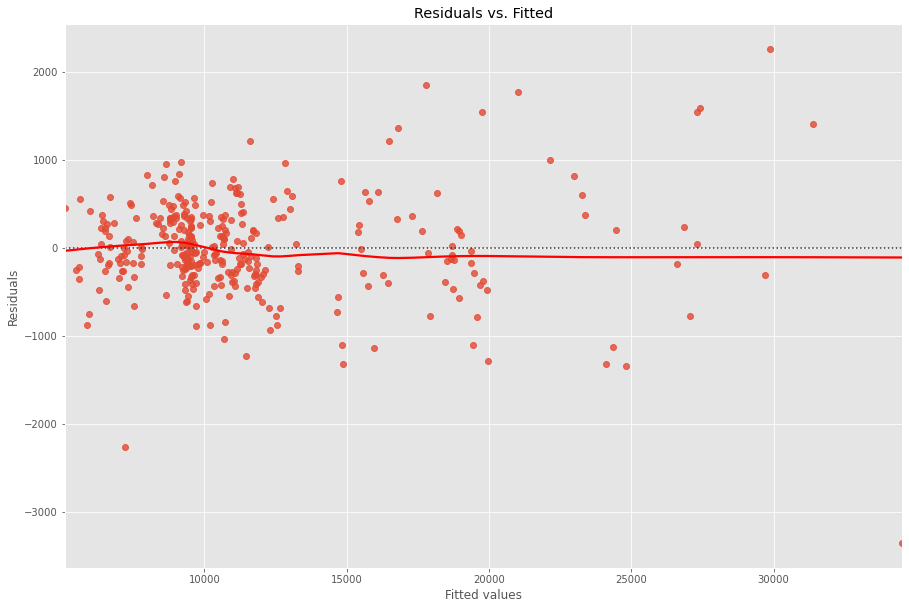

In [669]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model6_fitted_y_values, df_btc_CCC_dummies['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

Text(0, 0.5, 'Standardized residuals')

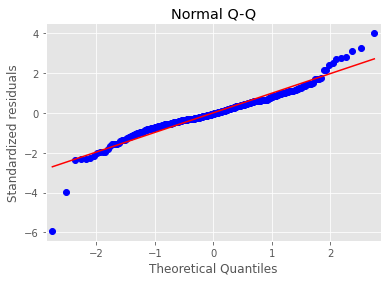

In [670]:
QQ = sgg.ProbPlot(model6_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

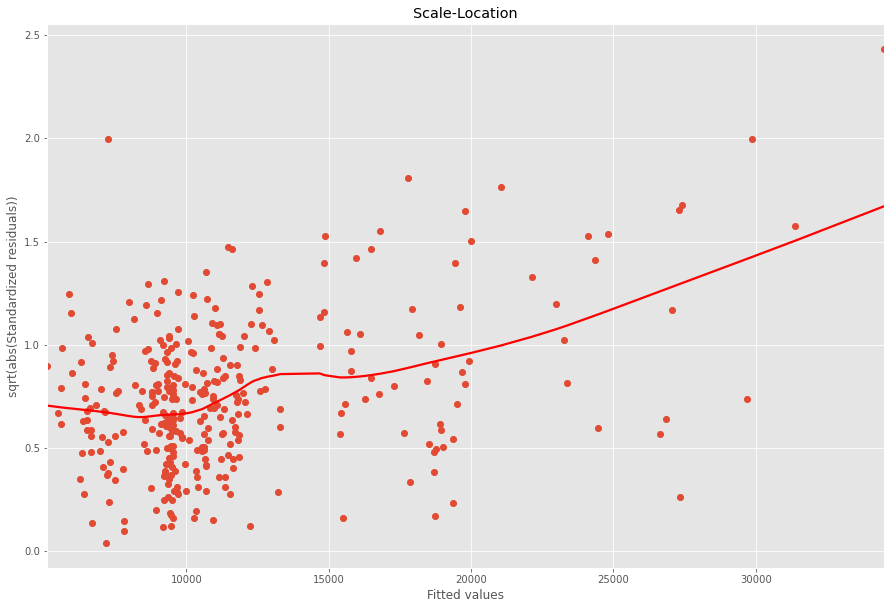

In [671]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model6_fitted_y_values, model6_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model6_fitted_y_values, model6_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('sqrt(abs(Standardized residuals))')
#constant variation and randomness of errors/residuals

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Standardized Residuals')

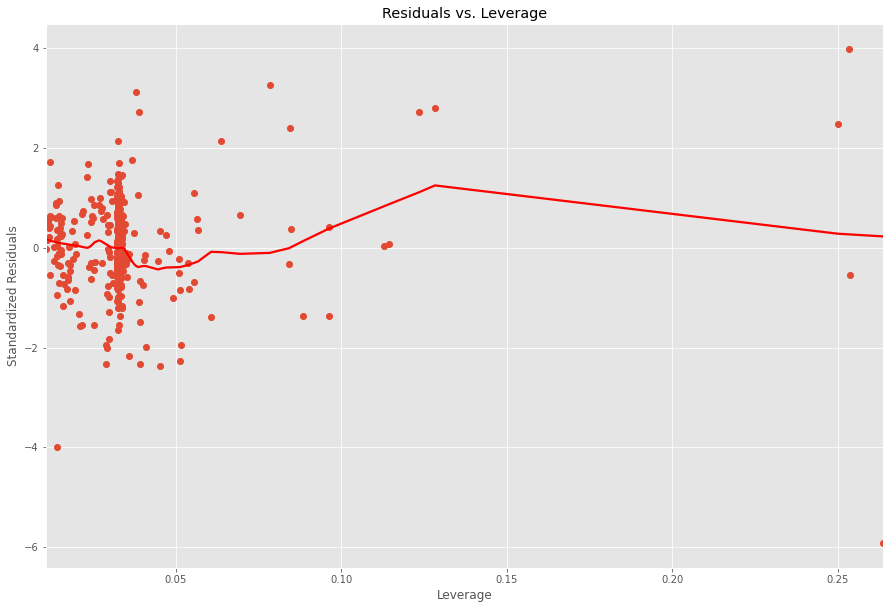

In [672]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model6_lev, model6_norm_resids)
sns.regplot(model6_lev, model6_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')

In [673]:
y_pred_6 = model6.predict(df_btc_CCC_dummies[['Relative_Time', 'Feb', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Jan', 'Close_LTC_lag_1', 'Close_XRP_lag_1']])

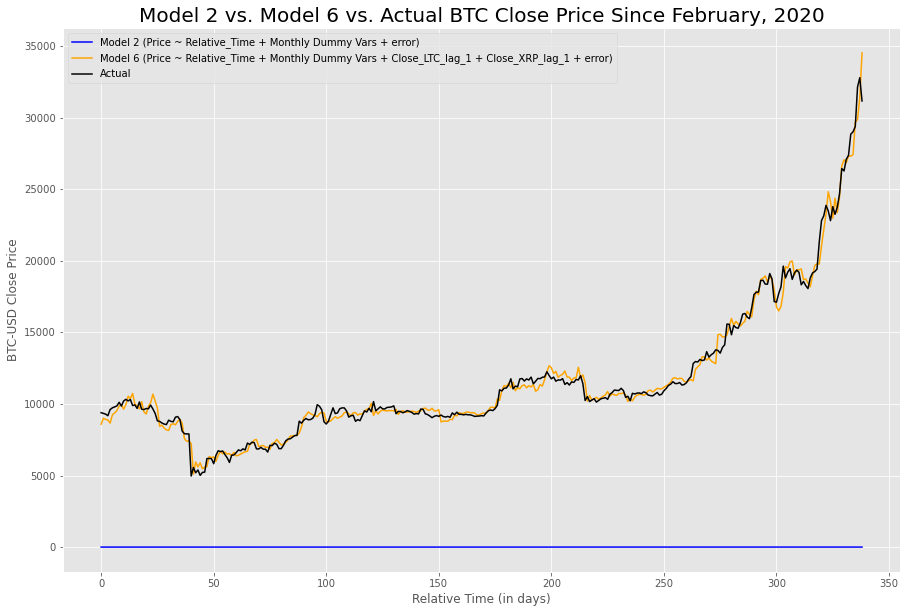

In [674]:
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_baseline_dummies['Relative_Time']
actual = df_btc_baseline['Close']
ax.plot(t, y_pred_2, color = 'blue', label = 'Model 2 (Price ~ Relative_Time + Monthly Dummy Vars + error)')
ax.plot(t, y_pred_6, color = 'orange', label = 'Model 6 (Price ~ Relative_Time + Monthly Dummy Vars + Close_LTC_lag_1 + Close_XRP_lag_1 + error)')
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.set_title('Model 2 vs. Model 6 vs. Actual BTC Close Price Since February, 2020', fontsize = 20)
ax.set_xlabel('Relative Time (in days)')
ax.set_ylabel('BTC-USD Close Price')
plt.legend()

In [675]:
df_btc_CCC_dummies['3_day_MA'] = float('NaN')

In [676]:
for i in range(3,len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['3_day_MA'][i] = df_btc_CCC_dummies['Close'][i-3:i].mean()

<ipython-input-676-d63143e25898>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['3_day_MA'][i] = df_btc_CCC_dummies['Close'][i-3:i].mean()


In [677]:
df_btc_CCC_dummies.columns.values

array(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Volume_Price', '10_Day_VWAP', 'Daily_Return', 'Biweekly_RS',
       'Biweekly_RSI', '12_day_EMA', '26_day_EMA', 'MACD', 'Signal',
       'Trend_Analysis_Close', 'Relative_Time', 'Month', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'Jan', 'Close_LTC_lag_1', 'Close_ETH_lag_1', 'Close_BNB_lag_1',
       'Close_BCH_lag_1', 'Close_XRP_lag_1', '3_day_MA'], dtype=object)

<AxesSubplot:xlabel='Relative_Time'>

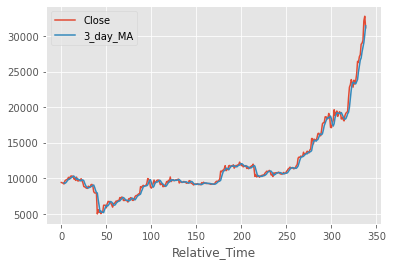

In [678]:
df_btc_CCC_dummies.plot('Relative_Time', ['Close', '3_day_MA'])

In [679]:
#calculate RMSE of 3-day MA model and other model...

In [680]:
df_btc_CCC_dummies[['pred_LR', 'Error_MA', 'Error_LR', 'Error_MA_sqr', 'Error_LR_sqr']] = float('NaN')

In [681]:
df_btc_CCC_dummies['Error_MA'] = df_btc_CCC_dummies['3_day_MA'] - df_btc_CCC_dummies['Close']

In [682]:
df_btc_CCC_dummies['Error_MA_sqr'] = df_btc_CCC_dummies['Error_MA']**2

In [683]:
for i in range(len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['pred_LR'][i] = y_pred_6[i]

<ipython-input-683-7da2f655b314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['pred_LR'][i] = y_pred_6[i]


In [684]:
df_btc_CCC_dummies['Error_LR'] = df_btc_CCC_dummies['pred_LR'] - df_btc_CCC_dummies['Close']

In [685]:
df_btc_CCC_dummies['Error_LR_sqr'] = df_btc_CCC_dummies['Error_LR']**2

In [686]:
RMSE_MA = np.sqrt(df_btc_CCC_dummies['Error_MA_sqr'].mean())
RMSE_MA

589.4587510119876

In [687]:
RMSE_LR = np.sqrt(df_btc_CCC_dummies['Error_LR_sqr'].mean())
RMSE_LR

556.7739581831303

In [688]:
df_btc_CCC_dummies.corr()['Close']

Open               0.996184
High               0.998141
Low                0.998248
Close              1.000000
Adj Close          1.000000
Volume             0.262853
Volume_Price       0.844762
10_Day_VWAP        0.991956
Daily_Return       0.155912
Biweekly_RS        0.315359
Biweekly_RSI       0.456138
12_day_EMA         0.992284
26_day_EMA         0.990513
MACD               0.774769
Signal             0.778353
Relative_Time      0.782630
Month              0.601274
Feb                0.441930
Mar               -0.123617
Apr               -0.307465
May               -0.279428
Jun               -0.152097
Jul               -0.134960
Aug               -0.130875
Sep                0.003083
Oct               -0.060266
Nov                0.018540
Dec                0.321555
Jan                0.674061
Close_LTC_lag_1    0.885180
Close_ETH_lag_1    0.939803
Close_BNB_lag_1    0.827880
Close_BCH_lag_1    0.341265
Close_XRP_lag_1    0.628693
3_day_MA           0.994288
pred_LR            0

In [689]:
#ARIMA, RNN, and other time-series models to implement...

In [690]:
#MA, AR, ARMA, then ARIMA modeling in that order...

In [691]:
#first, detrend and deseasonalize the data...Model_2 is a pure trend/seasonal model of BTC price, 
#therefore subtract this model' predictions from actual prices
df_btc_CCC_dummies['Close_Detrended_Deseasonalized'] = df_btc_CCC_dummies['Close'] - e**y_pred_2

<AxesSubplot:title={'center':'BTC-USD Detrended/Deseasonalized Price Since February, 2020'}, xlabel='Relative_Time'>

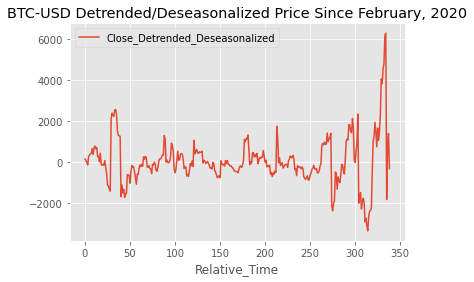

In [692]:
df_btc_CCC_dummies.plot('Relative_Time', 'Close_Detrended_Deseasonalized', title = 'BTC-USD Detrended/Deseasonalized Price Since February, 2020')

In [693]:
#perform Box-Cox Transformation on Close for BTC to remove variance issue from decomposition process

In [694]:
BTC_transformed, lmda = stats.boxcox(df_btc_CCC_dummies['Close'])
print("Best lambda for transformation:", lmda)

Best lambda for transformation: -0.6988220048445701


In [695]:
BTC_t_series = pd.Series(data=BTC_transformed,
                              index=df_btc_CCC_dummies['Relative_Time'].values)
BTC_t_series.reset_index(inplace = True, drop = True)

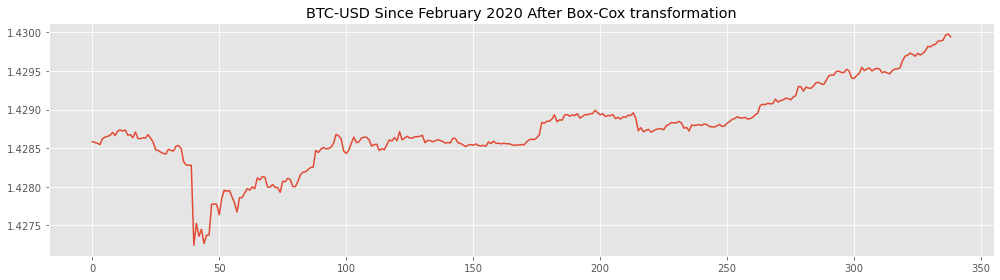

In [696]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(BTC_t_series.index, BTC_t_series.values)
ax.set_title("BTC-USD Since February 2020 After Box-Cox transformation")
fig.tight_layout()

In [697]:
df_btc_CCC_dummies['Close_transformed'] = BTC_transformed

In [698]:
#Now detrend and deseasonalize BTC_transformed
model_transformed = ols('Close_transformed ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan', data = df_btc_CCC_dummies).fit()
model_transformed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Close_transformed   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     275.8
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          1.28e-162
Time:                        12:29:18   Log-Likelihood:                 2497.6
No. Observations:                 339   AIC:                            -4969.
Df Residuals:                     326   BIC:                            -4919.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3185      0.000   8163.181      0.000       1.318       1.319
Relative_Time  2.734e-06   9.68e-07      2.825      0.005     8.3e-07    4.64e-06
Feb               0.1106      0.000    615.389      0.000       0.110       0.111
Mar               0.1101      0.000    732.341      0.000       0.110       0.110
Apr               0.1093      0.000    897.929      0.000       0.109       0.110
May               0.1094   9.34e-05   1172.033      0.000       0.109       0.110
Jun               0.1098   6.56e-05   1673.885      0.000       0.110       0.110
Jul               0.1098    4.1e-05   2680.045      0.000       0.110       0.110
Aug               0.1097   2.74e-05   4003.610      0.000       0.110       0.110
Sep               0.1099   4.02e-05   2732.840      0.000       0.110       0.110
Oct               0.1097   6.52e-05   1682.622      0.000       0.110       0.110
Nov               0.1098   9.26e-05   1184.883      0.000       0.110       0.110
Dec               0.1101      0.000    908.120      0.000       0.110       0.110
Jan               0.1103      0.000    735.018      0.000       0.110       0.111
==============================================================================
Omnibus:                       60.935   Durbin-Watson:                   0.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              651.652
Skew:                           0.291   Prob(JB):                    3.13e-142
Kurtosis:                       9.767   Cond. No.                     1.39e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.69e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [699]:
df_btc_CCC_dummies['Close_transformed_detrended_deseasonalized'] = model_transformed.predict(df_btc_CCC_dummies[['Relative_Time', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']]) - df_btc_CCC_dummies['Close_transformed']

<AxesSubplot:xlabel='Relative_Time'>

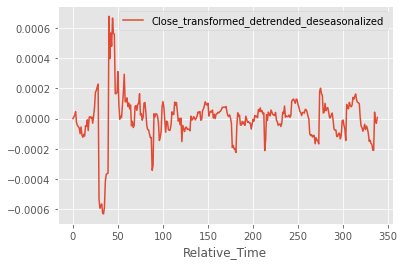

In [700]:
df_btc_CCC_dummies.plot('Relative_Time', 'Close_transformed_detrended_deseasonalized')

In [701]:
#still variance issue!
#try difference series to detrend BTC-USD Close Price
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    plt.tight_layout()

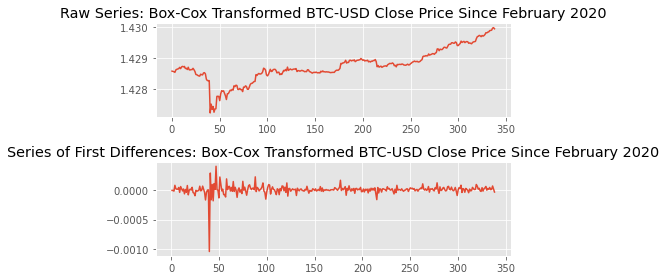

In [702]:
fig, axs = plt.subplots(2, 1)
plot_series_and_difference(axs, BTC_t_series, 'Box-Cox Transformed BTC-USD Close Price Since February 2020')

In [703]:
BTC_orig_t_series = pd.Series(data=df_btc_CCC_dummies['Close'].values,
                              index=df_btc_CCC_dummies['Relative_Time'].values)
BTC_orig_t_series.reset_index(inplace = True, drop = True)

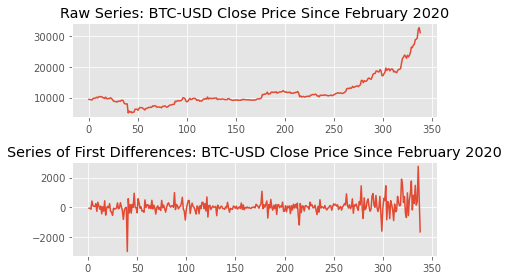

In [704]:
fig, axs = plt.subplots(2, 1)
plot_series_and_difference(axs, BTC_orig_t_series, 'BTC-USD Close Price Since February 2020')

Variance still isn't stable, try taking log of BTC-USD Close price, then applying Box-Cox transformation and differencing, compare and choose best result!

In [705]:
df_btc_CCC_dummies['log_10(Close)'] = np.log10(df_btc_CCC_dummies['Close'])

<AxesSubplot:xlabel='Relative_Time'>

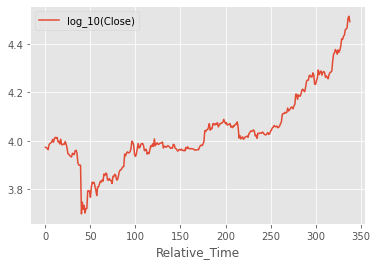

In [706]:
df_btc_CCC_dummies.plot('Relative_Time', 'log_10(Close)')

In [707]:
df_btc_CCC_dummies['ln(Close)'] = np.log(df_btc_CCC_dummies['Close'])

<AxesSubplot:xlabel='Relative_Time'>

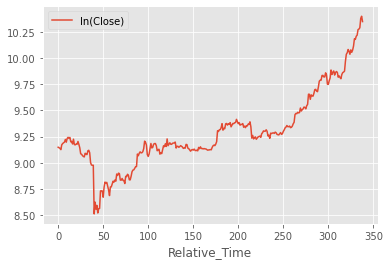

In [708]:
df_btc_CCC_dummies.plot('Relative_Time', 'ln(Close)')

In [709]:
#cannot remove minor variance issue even with log10() or ln() of Close, so the corresponding time segment of the prediction with high variance will be inaccurate...

In [710]:
test = sm.tsa.stattools.adfuller(BTC_t_series.diff()[1:])
print("ADF p-value for Differenced Box-Cox series: {0}".format(test[1]))

ADF p-value for Differenced Box-Cox series: 7.836090568317848e-11


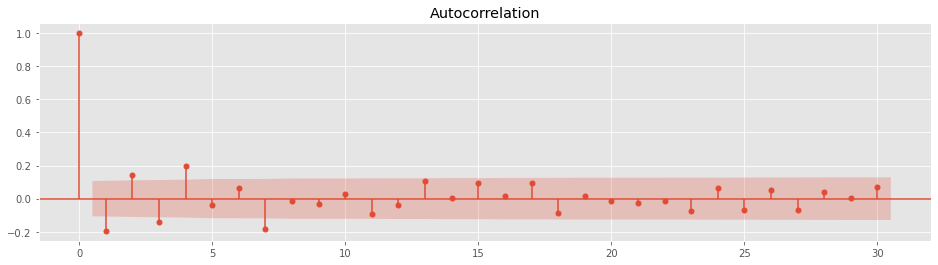

In [711]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(BTC_t_series.diff()[1:], lags=30, ax=ax)

In [712]:
#MA modeling, 4 additional lags is statistically significant based on ACF plot
model_ma = ARIMA(BTC_t_series, order=(0, 1, 4))
model_ma.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [713]:
pred_ma = model_ma.predict(BTC_t_series)

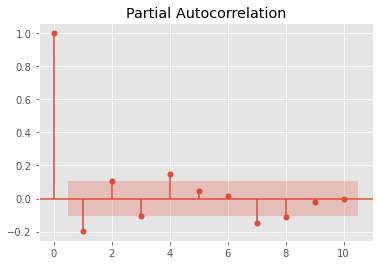

In [714]:
_ = sm.graphics.tsa.plot_pacf(BTC_t_series.diff()[1:], lags=10)

In [715]:
#AR modeling, 4 additional lags is statistically significant based on PACF plot
model_ar = ARIMA(BTC_t_series, order=(4, 1, 0))
model_ar.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [716]:
pred_ar = model_ar.predict(BTC_t_series)

In [717]:
#ARIMA modeling
model_arima = ARIMA(BTC_t_series, order = (4, 1, 4))
model_arima.fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning

In [718]:
pred_arima = model_arima.predict(BTC_t_series)

In [719]:
parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 0, 'MA': 2},
    {'AR': 0, 'MA': 3},
    {'AR': 0, 'MA': 4},
    {'AR': 1, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 0},
    {'AR': 2, 'MA': 1},
    {'AR': 2, 'MA': 2},
    {'AR': 3, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 3, 'MA': 2},
    {'AR': 3, 'MA': 4},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 4, 'MA': 2},
    {'AR': 4, 'MA': 3},
    {'AR': 4, 'MA': 4}
]


models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(BTC_t_series, order=(params['AR'], 1, params['MA'])).fit()
    
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))


C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(0, 1, 0) AIC: -5415.434784663194
ARIMA(0, 1, 1) AIC: -5424.191874476143
ARIMA(0, 1, 2) AIC: -5423.743662665626
ARIMA(0, 1, 3) AIC: -5425.0191647923375
ARIMA(0, 1, 4) AIC: -5434.260165518875
ARIMA(1, 1, 0) AIC: -5426.531746063892
ARIMA(1, 1, 1) AIC: -5433.962941460384
ARIMA(2, 1, 0) AIC: -5428.388133299554
ARIMA(2, 1, 1) AIC: -5433.396403083341
ARIMA(2, 1, 2) AIC: -5431.023044458595
ARIMA(3, 1, 0) AIC: -5429.98114834071
ARIMA(3, 1, 1) AIC: -5427.249092614748
ARIMA(3, 1, 2) AIC: -5424.87758400909
ARIMA(3, 1, 4) AIC: -5420.106246622233
ARIMA(4, 1, 0) AIC: -5435.407903615955
ARIMA(4, 1, 1) AIC: -5433.699945935976
ARIMA(4, 1, 2) AIC: -5431.822830719497
ARIMA(4, 1, 3) AIC: -5433.735694002205
ARIMA(4, 1, 4) AIC: -5430.922969827934


C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning

In [720]:
# Fit your model
model_auto_arima = pm.auto_arima(BTC_t_series, seasonal=False)

In [721]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  339
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2720.882
Date:                Mon, 11 Jan 2021   AIC                          -5435.765
Time:                        12:30:30   BIC                          -5424.296
Sample:                             0   HQIC                         -5431.194
                                - 339                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8221    2.2e-19  -3.74e+18      0.000      -0.822      -0.822
ma.L1          0.6620   1.01e-19   6.58e+18      0.000       0.662       0.662
sigma2      5.661e-09   6.59e-11     85.952      0.000    5.53e-09    5.79e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            131859.66
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -6.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.66e+33. Standard errors may be unstable.
"""

In [722]:
# make your forecasts
forecasts = model_auto_arima.predict(1)  # predict N steps into the future

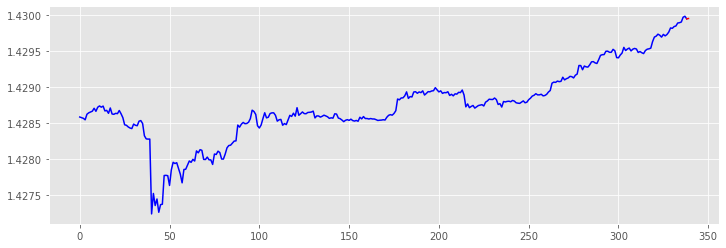

In [723]:
# Visualize the forecasts
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(BTC_t_series.index.values, BTC_t_series.values, c='blue')
ax.plot([338, 339], [BTC_t_series[338], forecasts], c='red')

In [444]:
models_arima = []
for i in range(1,31):
    models_arima.append(pm.auto_arima(BTC_t_series, seasonal = True, m = i))
for model in models_arima:
    print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  339
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2720.882
Date:                Fri, 08 Jan 2021   AIC                          -5435.765
Time:                        20:05:43   BIC                          -5424.296
Sample:                             0   HQIC                         -5431.194
                                - 339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8221    2.2e-19  -3.74e+18      0.000      -0.822      -0.822
ma.L1          0.6620   1.01e-19   6.58e+18      0.000       0.662       0.662
sigma2      5.661e-09   6.59e-11     85.952      0.0

[2] Covariance matrix is singular or near-singular, with condition number 3.66e+33. Standard errors may be unstable.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  339
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2720.882
Date:                Fri, 08 Jan 2021   AIC                          -5435.765
Time:                        20:05:43   BIC                          -5424.296
Sample:                             0   HQIC                         -5431.194
                                - 339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8221    2.2e-19  -3.74e+18      0.000      -0.822      -0.822
ma.L1         

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  339
Model:               SARIMAX(4, 1, 0)   Log Likelihood                2723.235
Date:                Fri, 08 Jan 2021   AIC                          -5436.470
Time:                        20:05:44   BIC                          -5417.355
Sample:                             0   HQIC                         -5428.852
                                - 339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1442   2.01e-20  -7.18e+18      0.000      -0.144      -0.144
ar.L2          0.0794   1.11e-19   7.13e+17      0.000       0.079       0.079
ar.L3         -0.0755   7.09e-20  -1.06e+18      0.0

In [738]:
#best model via AIC: SARIMAX(order = (1,1,1), seasonal_order = (0,0,1,7))
#best model via Log Likelihood" SARIMAX(order = (4,1,0), seasonal_order = (1,0,0,15))

In [728]:
weekly_model = SARIMAX(BTC_t_series, order = (1, 1, 1), seasonal_order=(0, 0, 1, 7)).fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [729]:
biweekly_model = SARIMAX(BTC_t_series, order = (4, 1, 0), seasonal_order = (1, 0, 0, 15)).fit()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


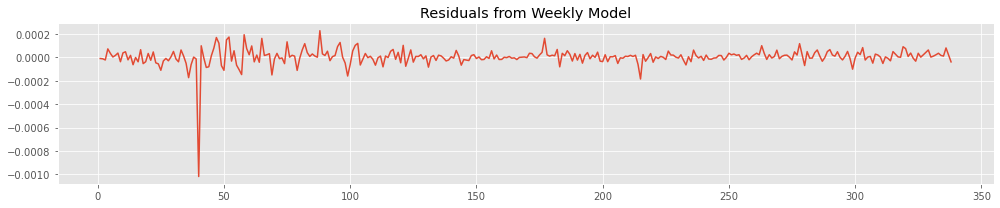

In [730]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(weekly_model.resid.index[1:], weekly_model.resid[1:])
ax.set_title("Residuals from Weekly Model")
plt.tight_layout()

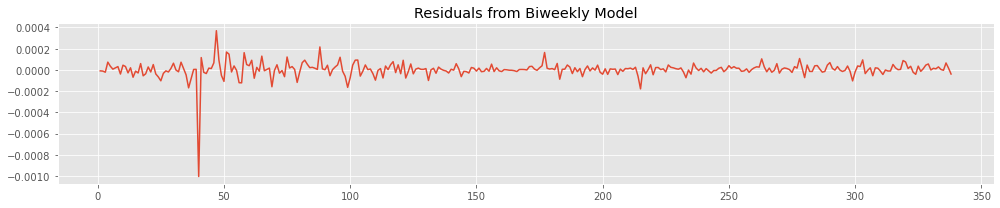

In [731]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(biweekly_model.resid.index[1:], biweekly_model.resid[1:])
ax.set_title("Residuals from Biweekly Model")
plt.tight_layout()

In [732]:
#residuals = actual - predicted, therefore predicted = actual - residuals

In [733]:
df_btc_CCC_dummies[['ARIMA_biweekly_pred', 'ARIMA_weekly_pred']] = float('NaN')

In [734]:
for i in range(1,len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['ARIMA_weekly_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - weekly_model.resid[i]
    df_btc_CCC_dummies['ARIMA_biweekly_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - biweekly_model.resid[i]

<ipython-input-734-932960344c0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['ARIMA_weekly_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - weekly_model.resid[i]
<ipython-input-734-932960344c0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['ARIMA_biweekly_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - biweekly_model.resid[i]


In [735]:
df_btc_CCC_dummies[['ARIMA_weekly_pred_untransf', 'ARIMA_biweekly_pred_untransf']] = float('NaN')

In [736]:
for i in range(1, len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_weekly_pred'][i], -0.6988220048445701)
    df_btc_CCC_dummies['ARIMA_biweekly_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_biweekly_pred'][i], -0.6988220048445701)

<ipython-input-736-a913e8a5a66a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_weekly_pred'][i], -0.6988220048445701)
<ipython-input-736-a913e8a5a66a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['ARIMA_biweekly_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_biweekly_pred'][i], -0.6988220048445701)


In [739]:
df_btc_CCC_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 2020-02-01 to 2021-01-04
Data columns (total 50 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Open                                        339 non-null    float64
 1   High                                        339 non-null    float64
 2   Low                                         339 non-null    float64
 3   Close                                       339 non-null    float64
 4   Adj Close                                   339 non-null    float64
 5   Volume                                      339 non-null    int64  
 6   Volume_Price                                339 non-null    float64
 7   10_Day_VWAP                                 339 non-null    float64
 8   Daily_Return                                339 non-null    float64
 9   Biweekly_RS                                 339 non-null    float64
 10  Biw

In [741]:
df_btc_CCC_dummies[['Error_ARIMA_weekly', 'Error_ARIMA_biweekly', 'Error_ARIMA_weekly_sqr', 'Error_ARIMA_biweekly_sqr']] = float('NaN')

In [742]:
for i in range(1, len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['Error_ARIMA_weekly'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i]
    df_btc_CCC_dummies['Error_ARIMA_biweekly'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_biweekly_pred_untransf'][i]
    df_btc_CCC_dummies['Error_ARIMA_weekly_sqr'][i] = df_btc_CCC_dummies['Error_ARIMA_weekly'][i]**2
    df_btc_CCC_dummies['Error_ARIMA_biweekly_sqr'][i] = df_btc_CCC_dummies['Error_ARIMA_biweekly'][i]**2

<ipython-input-742-425edf775e58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['Error_ARIMA_weekly'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i]
<ipython-input-742-425edf775e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_CCC_dummies['Error_ARIMA_biweekly'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_biweekly_pred_untransf'][i]
<ipython-input-742-425edf775e58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [749]:
RMSE_ARIMA_weekly = np.sqrt(df_btc_CCC_dummies['Error_ARIMA_weekly_sqr'][1:].mean())

In [750]:
RMSE_ARIMA_biweekly = np.sqrt(df_btc_CCC_dummies['Error_ARIMA_biweekly_sqr'][1:].mean())

In [751]:
f'RMSE_MA: {RMSE_MA}, RMSE_LR: {RMSE_LR}, RMSE_ARIMA_weekly" {RMSE_ARIMA_weekly}, RMSE_ARIMA_biweekly: {RMSE_ARIMA_biweekly}'

'RMSE_MA: 589.4587510119876, RMSE_LR: 556.7739581831303, RMSE_ARIMA_weekly" 490.3573339910692, RMSE_ARIMA_biweekly: 464.1656010039839'

In [ ]:
#incorporate coin ranking and macroeconomic factors into LSTM model?